In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/predictive_distribution


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np
import jsons

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration, BaseConfiguration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentDataNAS, ExperimentDataNE
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimatorGenome
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions, plot_metrics_by_quantile
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions
from deep_learning.probabilistic.deser import ProbabilisticFeedForwardDeser
from deep_learning.probabilistic.evaluate_probabilistic_dl import EvaluateProbabilisticDL
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimatorNetwork 
from neat.analysis.experiment_data import ExperimentData
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_pca import plot_dimensionality_reduction
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.plotting.plot_prediction_probabilities import plot_prediction_probabilities
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

# Get NAS

In [8]:
DATASET = 'iris'

In [9]:
project_nas='nas'
algorithm_version_nas ='nas'
# correlation_ids_nas = ['nas_v1']
correlation_ids_nas = ['nas_v2_new_layer']

experiment_data_nas = ExperimentDataNAS(correlation_ids=correlation_ids_nas, dataset_name=DATASET, n_samples=1000,
                                    project=project_nas, algorithm_version=algorithm_version_nas,
                                    keep_top=1.0)
experiment_data_nas.process_data()
data_nas = experiment_data_nas.experiment_data
data_nas['version'] = 'NAS'
data_nas.head(1)

###########
CORRELATION ID: nas_v2_new_layer


,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,duration,end_condition,n_parameters,n_nodes,n_connections,f1,accuracy,version
0,nas_v2_new_layer,3edfd271-44e2-49b4-bd6e-176e9738a603,0.75,0.0,True,0.000001,0:02:10.853180,normal,246,18,105,0.947,94.736842,NAS


In [10]:
def _get_estimator_ne(experiment_data: ExperimentDataNE, execution_id, testing=True, dataset_random_state=None):
    genome = experiment_data.best_genomes[execution_id]
    config = experiment_data.configurations[execution_id]
    if dataset_random_state:
        config.dataset_random_state = dataset_random_state
    estimator = PredictionDistributionEstimatorGenome(genome, config=config, testing=testing, n_samples=1000)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile()
    return estimator


def _get_estimator_nas(experiment_data: ExperimentDataNAS, execution_id, testing=True, dataset_random_state=None, is_alternative=False):
    report = experiment_data.reports[execution_id]
    config = jsons.load(report.configuration, BaseConfiguration)
    if dataset_random_state:
        config.dataset_random_state = dataset_random_state
    network = ProbabilisticFeedForwardDeser.from_dict(report.best_network, is_alternative=is_alternative)
    
    estimator = PredictionDistributionEstimatorNetwork(network, config=config, testing=testing, n_samples=1000)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile()
    return estimator


def _evaluate_network_nas(experiment_data: ExperimentDataNAS, execution_id, is_testing=True, dataset_random_state=None, is_alternative=False):
    report = experiment_data.reports[execution_id]
    config = jsons.load(report.configuration, BaseConfiguration)
    if dataset_random_state:
        config.dataset_random_state = dataset_random_state
    print(config.dataset_random_state)
    print(config.n_samples)
    network = ProbabilisticFeedForwardDeser.from_dict(report.best_network, is_alternative=is_alternative)
    dataset = PredictionDistributionEstimatorNetwork(network, config=config, testing=None, n_samples=1000).get_dataset()
    
    
    evaluator = EvaluateProbabilisticDL(dataset=estimator_nas.get_dataset(),
                                        batch_size=1000000,
                                        n_samples=config.n_samples,
                                        lr=0.01,
                                        weight_decay=0.0005,
                                        n_epochs=None,
                                        n_neurons_per_layer=network.n_neurons_per_layer,
                                        n_hidden_layers=network.n_hidden_layers,
                                        is_cuda=False,
                                        beta=config.beta)
    evaluator._initialize()
    evaluator.best_network = network
    print(f'Is testing: {is_testing}')
    _, y_true, y_pred = evaluator.evaluate(is_testing=is_testing)
    y_true = y_true.numpy()
    y_pred = torch.argmax(y_pred, dim=1).numpy()
    accuracy = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    confusion_m = confusion_matrix(y_true, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Confusion Matrix: {confusion_m}')

In [22]:
testing=True
execution_id = '3edfd271-44e2-49b4-bd6e-176e9738a603'; is_alternative = False
execution_id = 'fb1da836-f5e2-4890-934d-b061919b43a9'; is_alternative = False
execution_id = 'f81b71d1-c5a3-43cd-85dc-0f2f13f71a3e'; is_alternative = True

In [23]:
estimator_nas = _get_estimator_nas(experiment_data=experiment_data_nas, execution_id=execution_id, 
                                   testing=testing, dataset_random_state=None, is_alternative=is_alternative)

Sum Train: 10.125177383422852
Training: 112. Testing: 38


In [24]:
_evaluate_network_nas(experiment_data=experiment_data_nas, execution_id=execution_id, 
                      is_testing=testing, dataset_random_state=None, is_alternative=is_alternative)

35
100
Sum Train: 10.125177383422852
Training: 112. Testing: 38
Is testing: True
Accuracy: 94.73684210526315
F1: 0.9470003680529997
Confusion Matrix: [[14  0  0]
 [ 0 10  2]
 [ 0  0 12]]


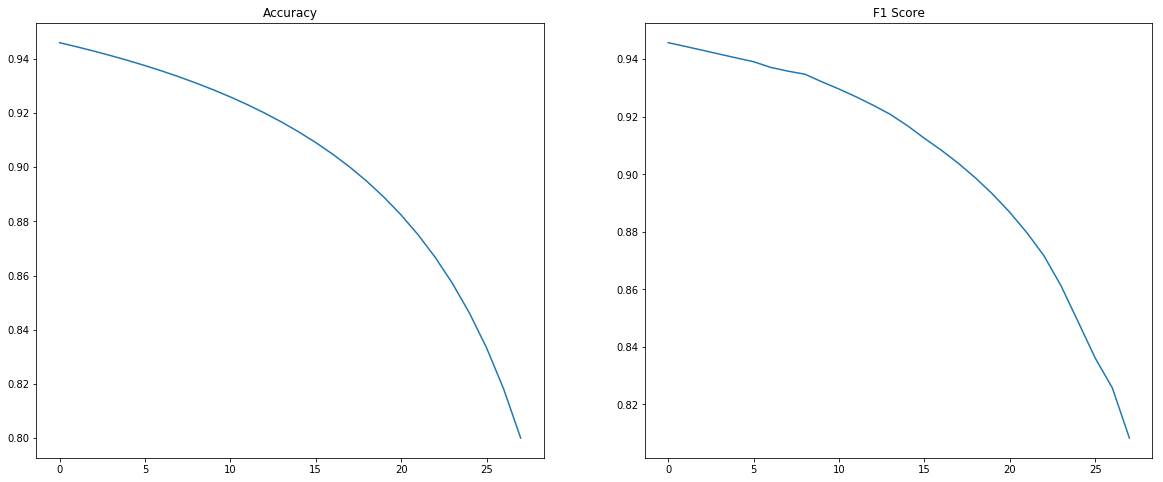

In [28]:
plot_metrics_by_quantile(metrics_by_quantile=estimator_nas.metrics_by_quantile)

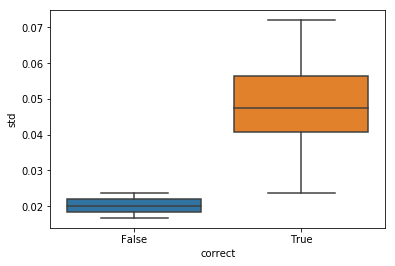

In [26]:
sns.boxplot(data=estimator_nas.results_enriched, x='correct', y='std')

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.0385548360645771


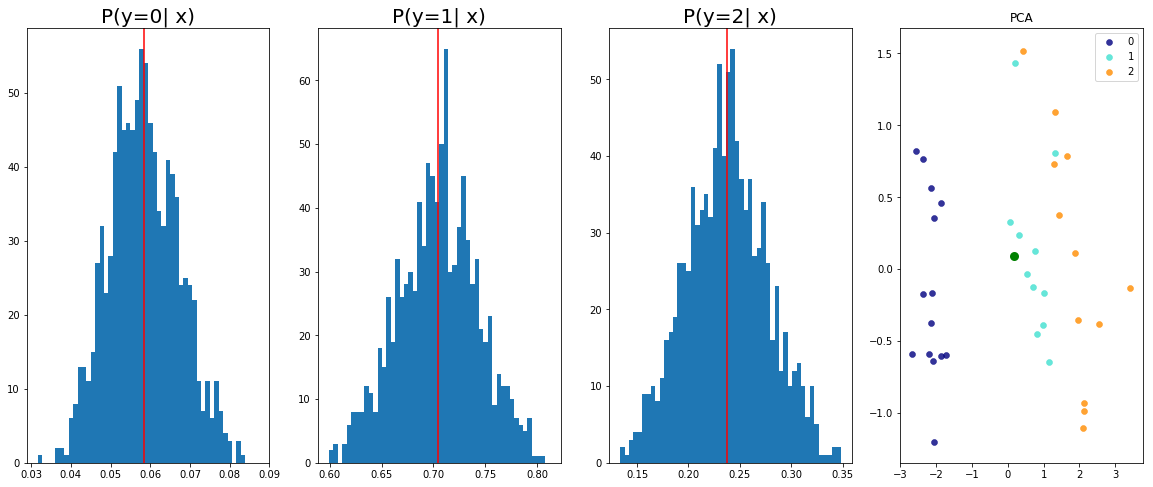

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.04293253645300865


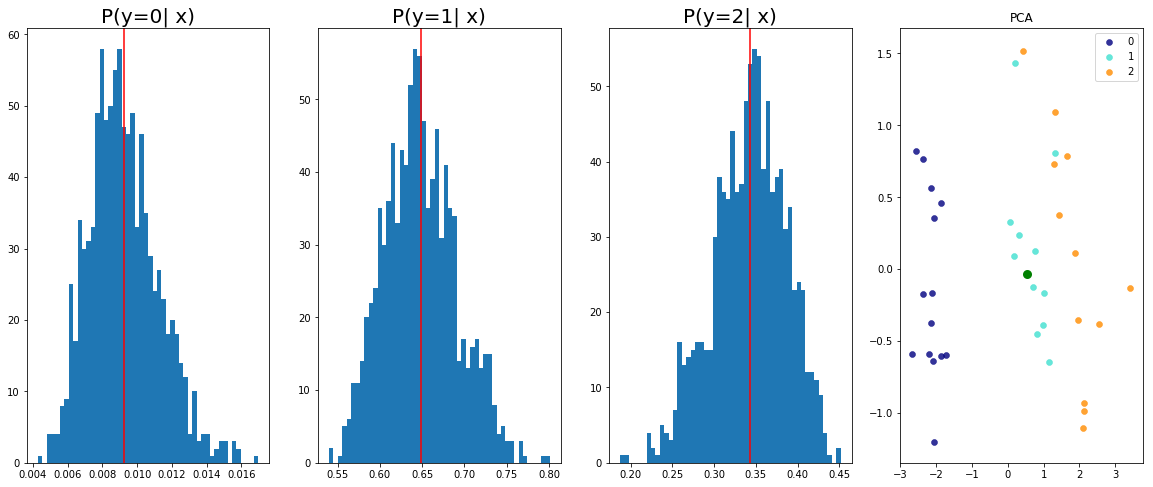

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.0688532367348671


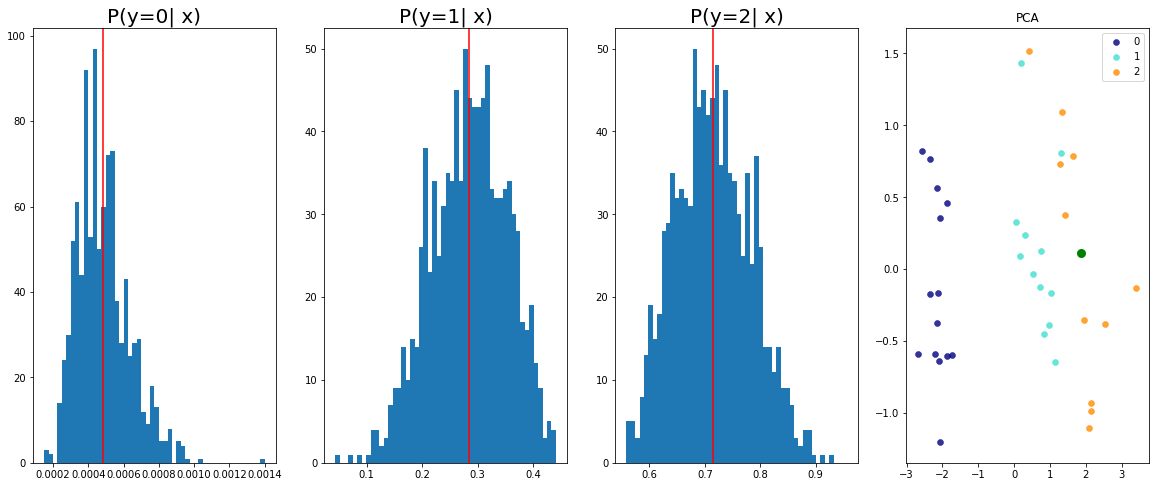

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 2
STDS: 0.01671125926077366


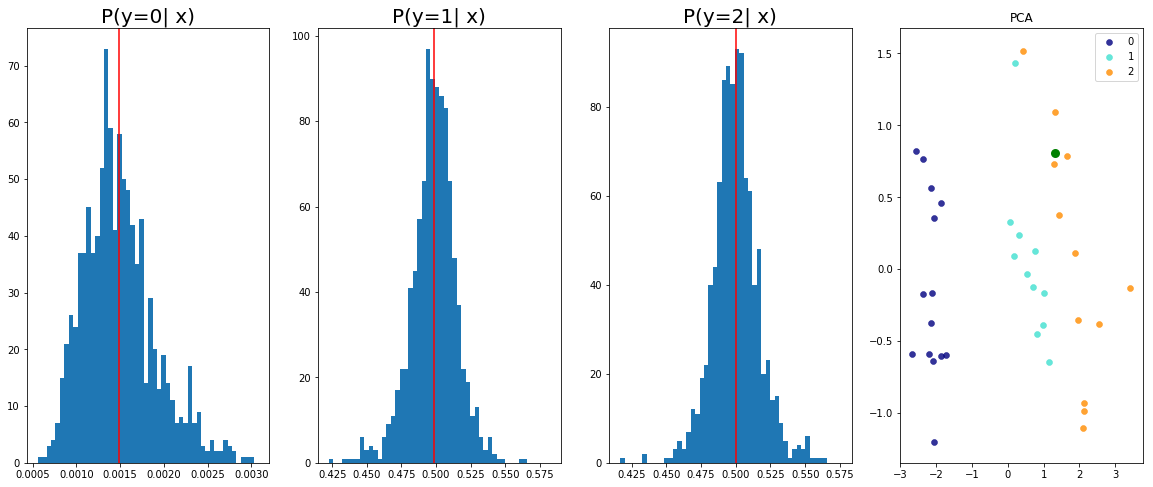

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.044342994689941406


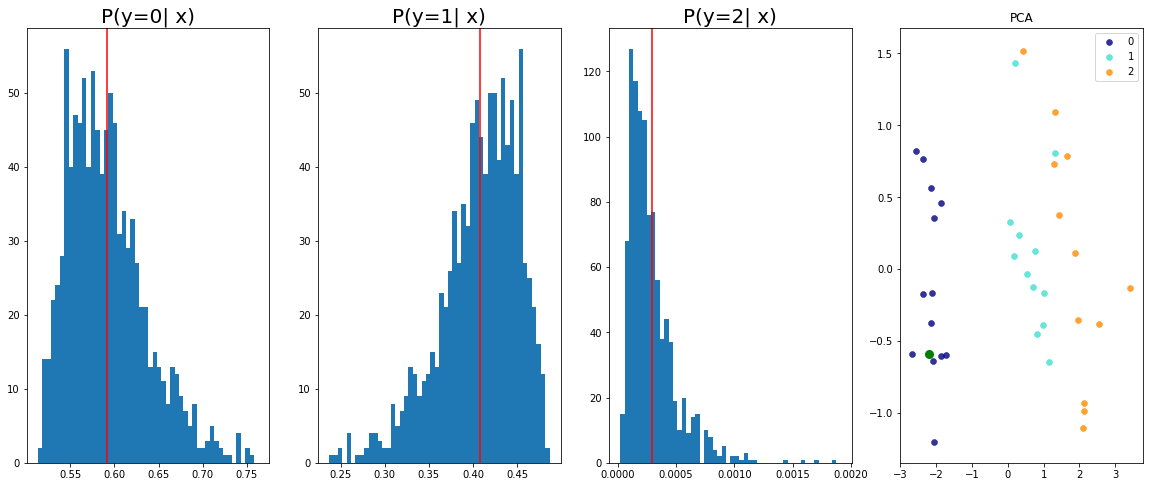

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.0720306932926178


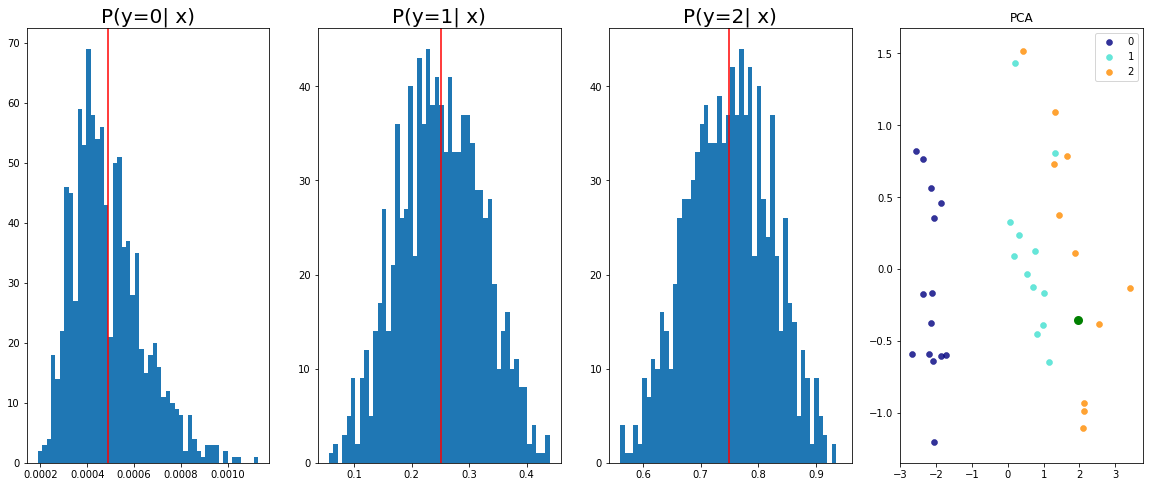

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.04104508087038994


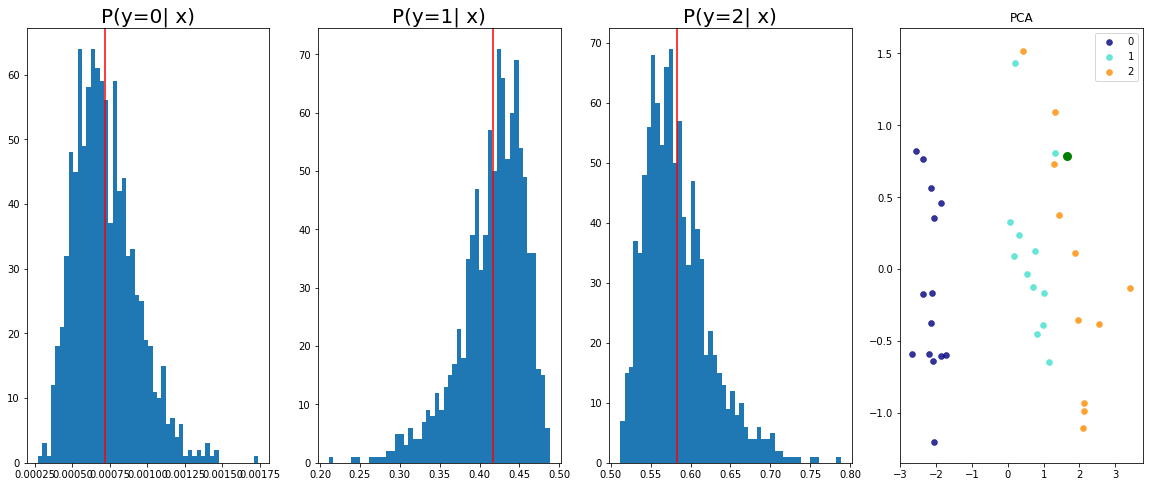

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.03888339549303055


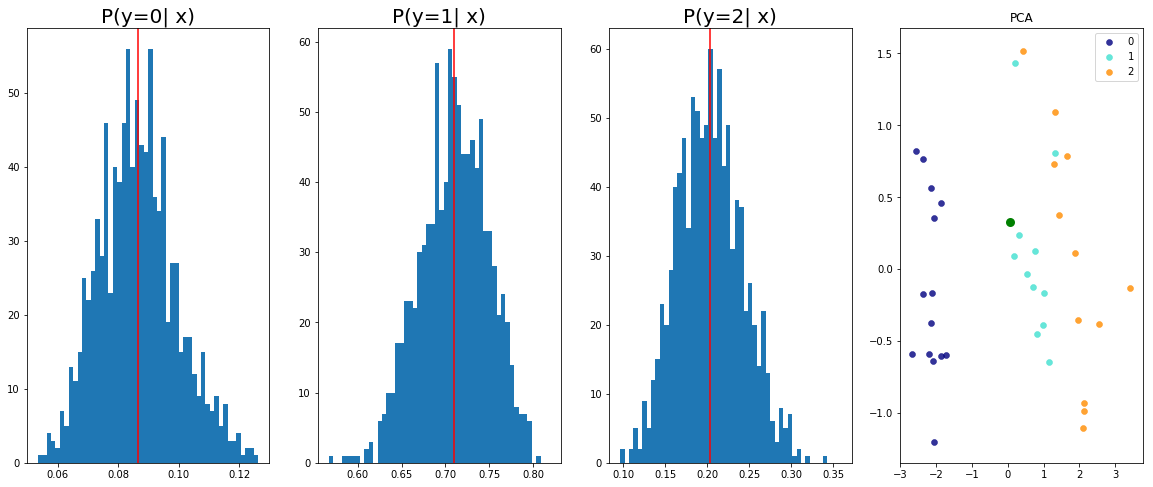

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.030037380754947662


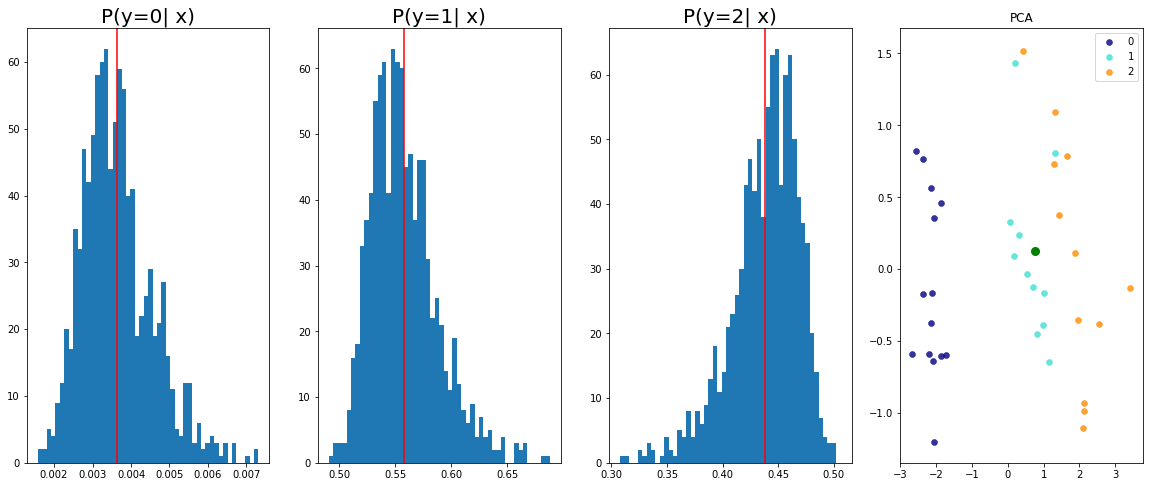

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.04535934701561928


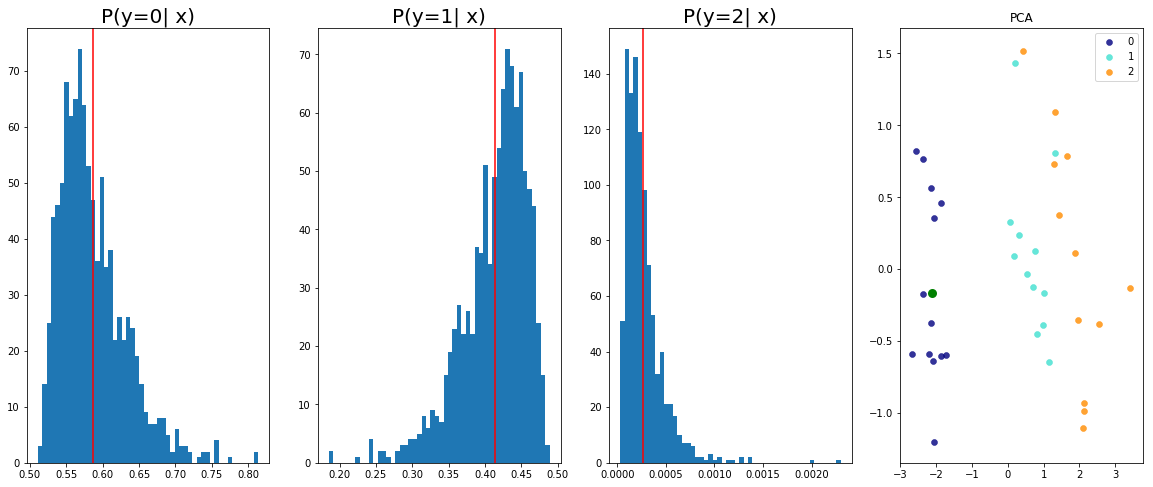

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.03593238815665245


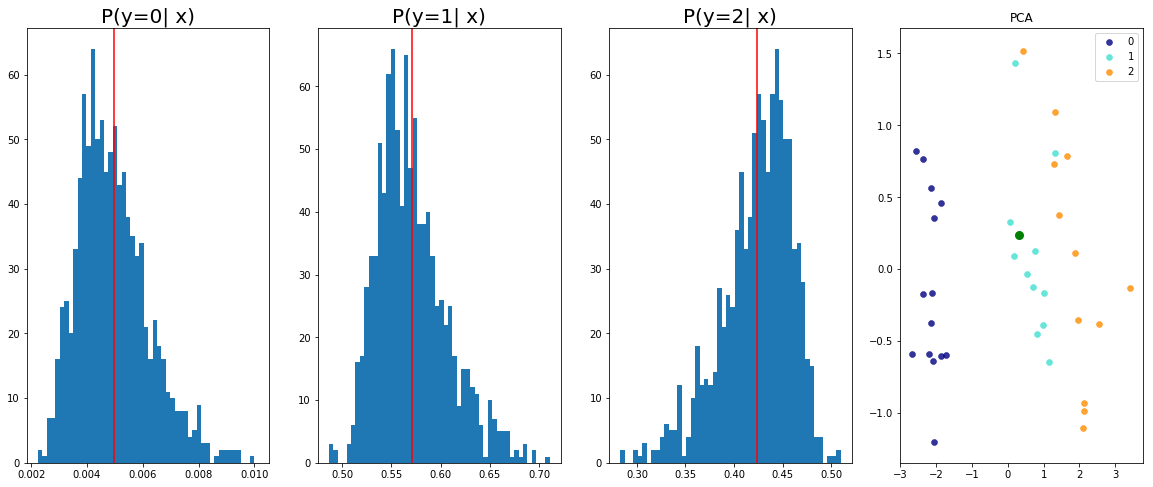

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.06989608705043793


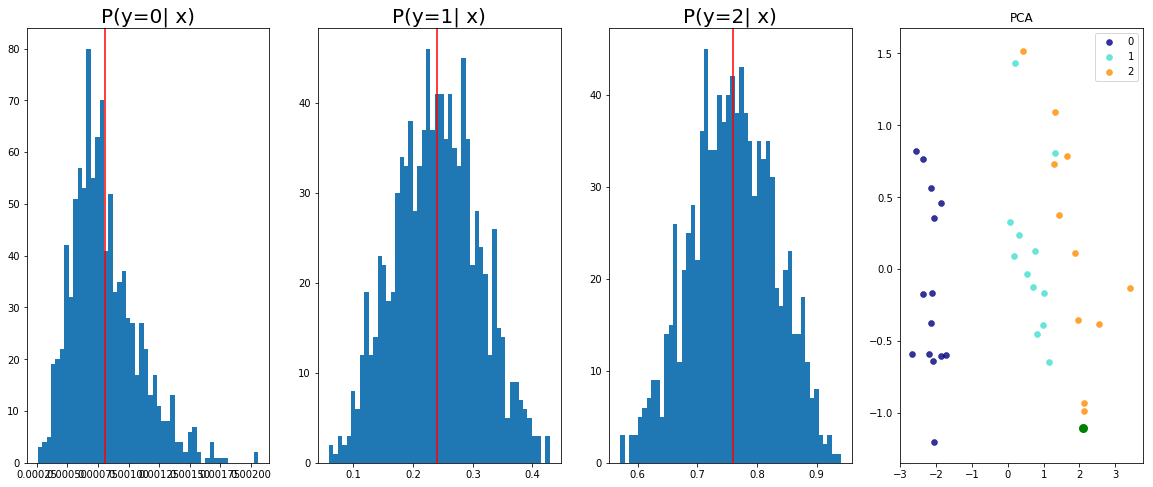

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.04630487412214279


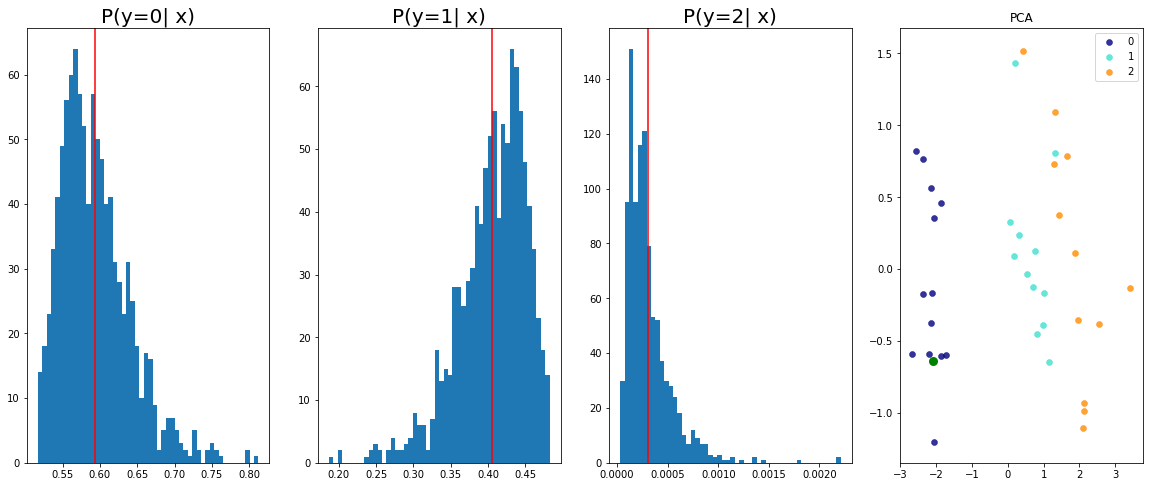

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.06901101022958755


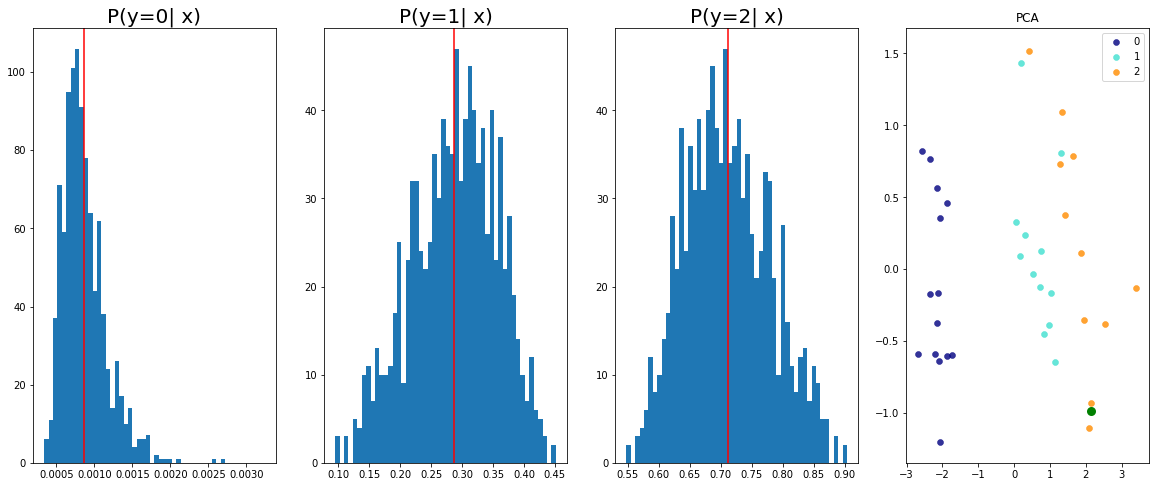

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.05341600999236107


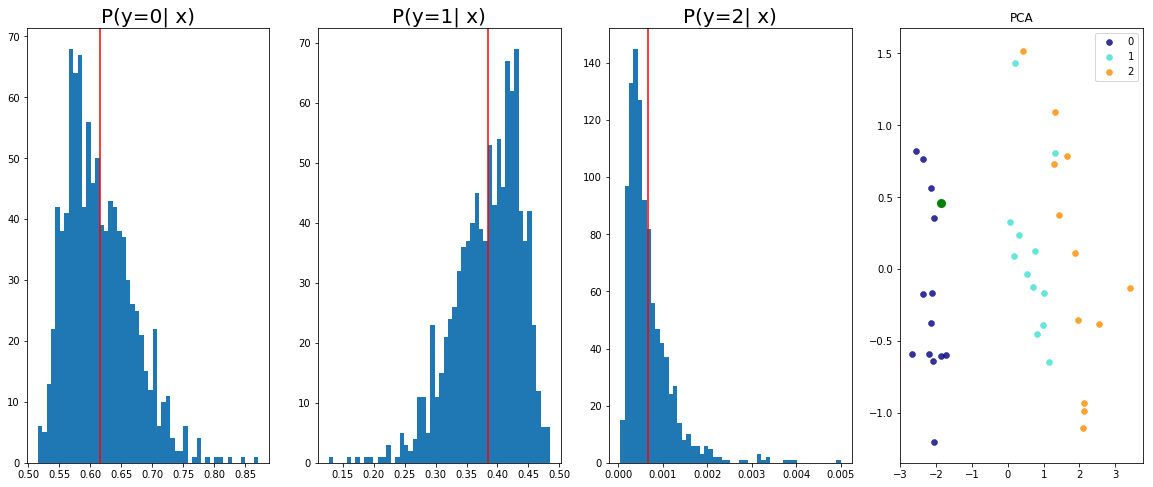

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.05784902349114418


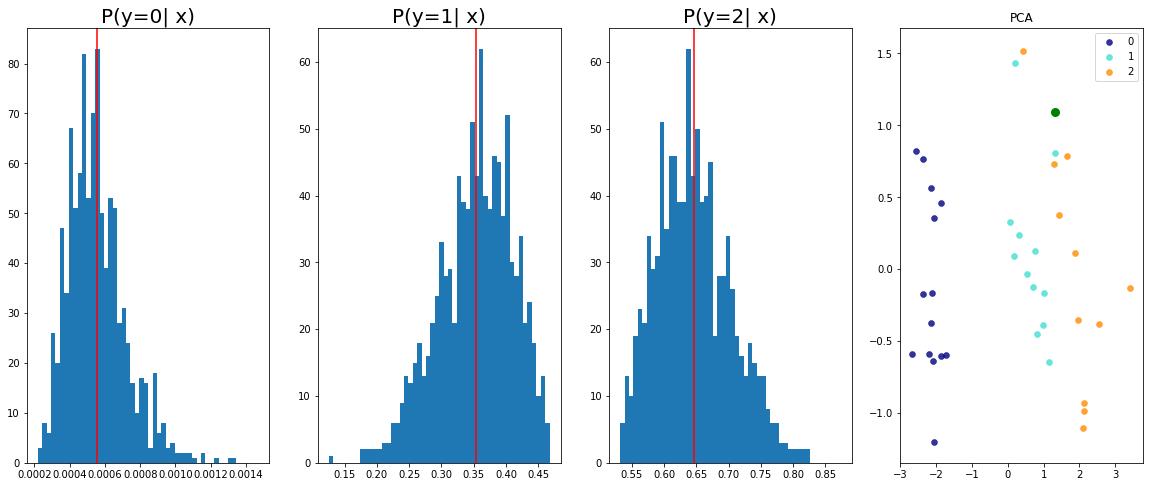

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.030938219279050827


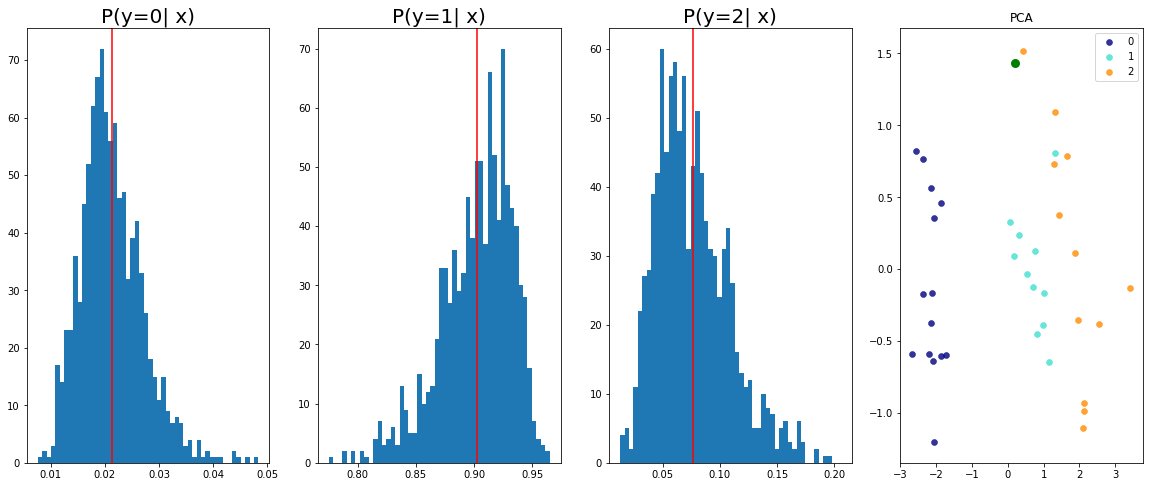

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.054757989943027496


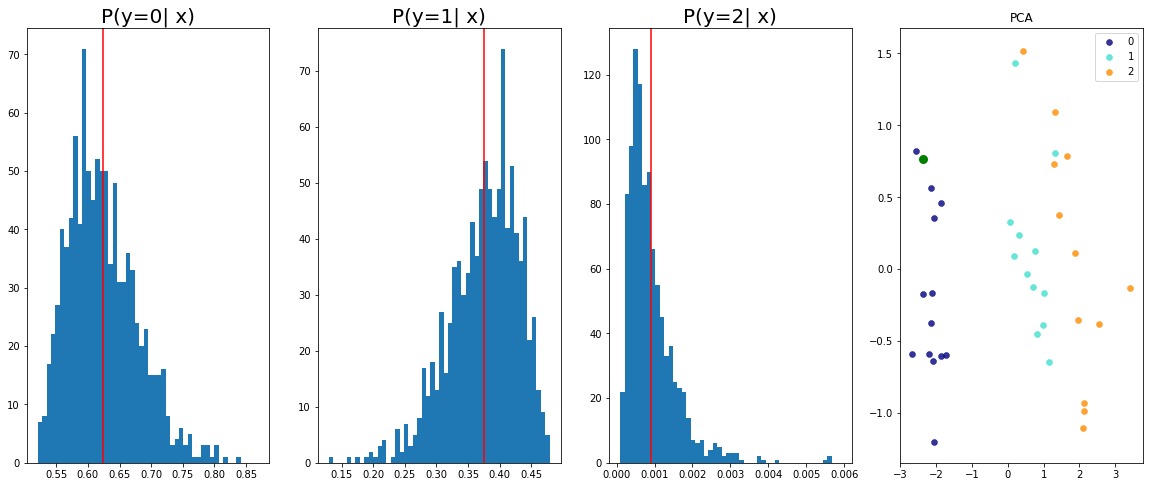

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.04869798198342323


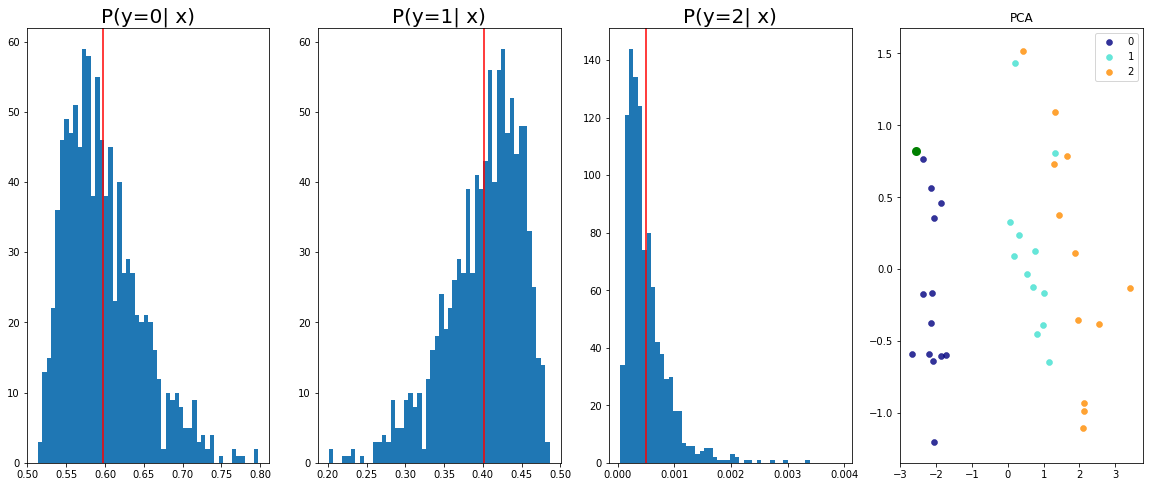

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.0537203811109066


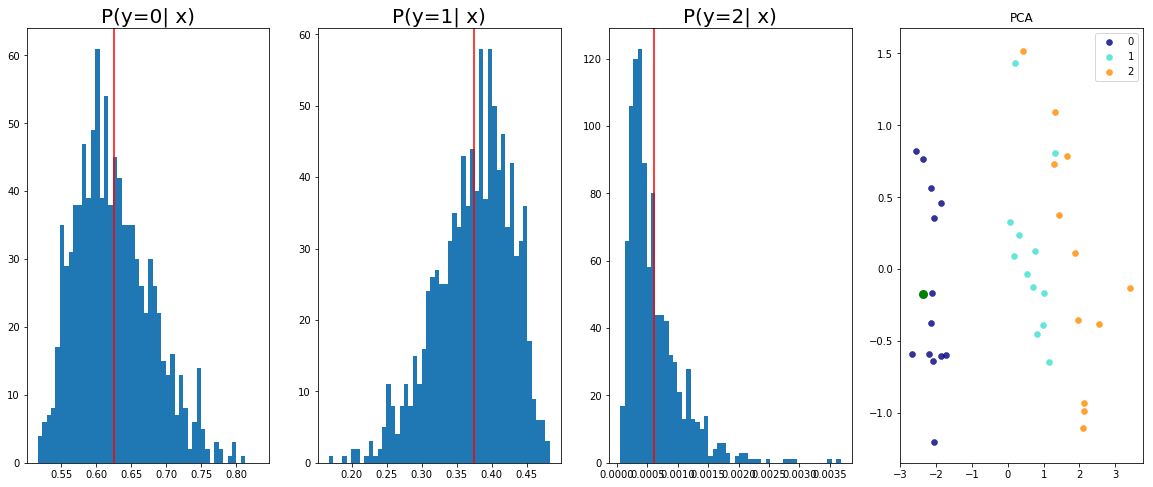

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.052650079131126404


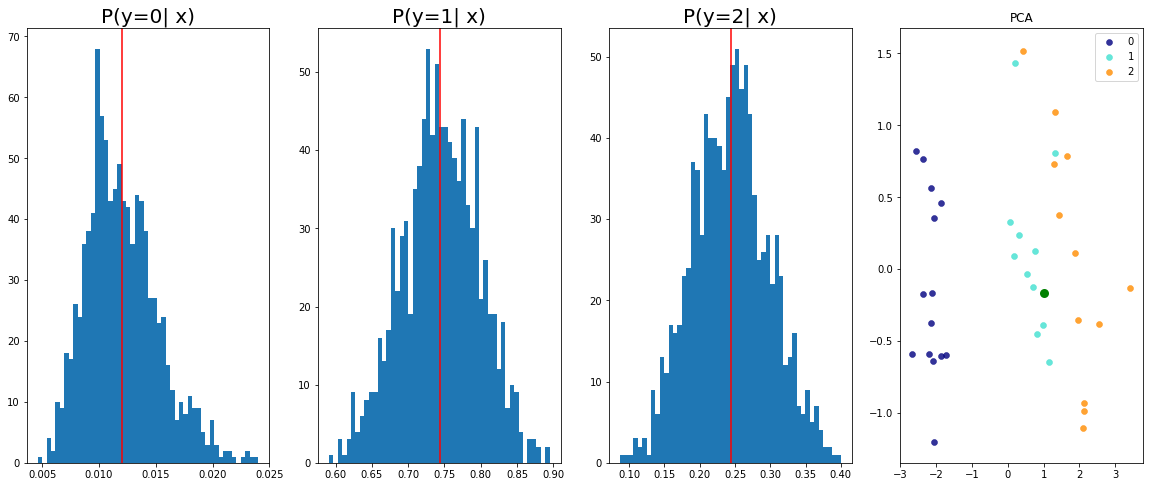

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.04258937016129494


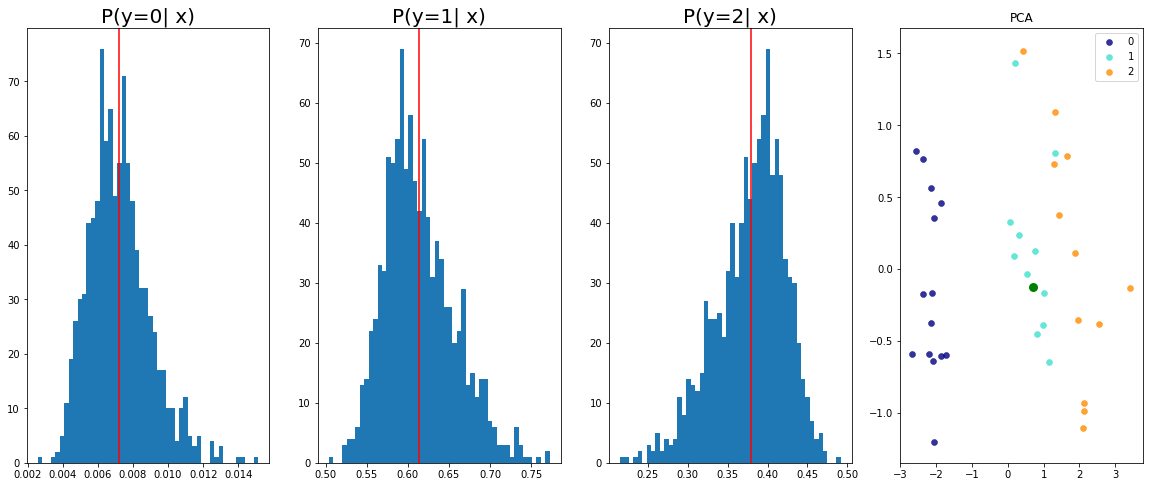

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.07199814915657043


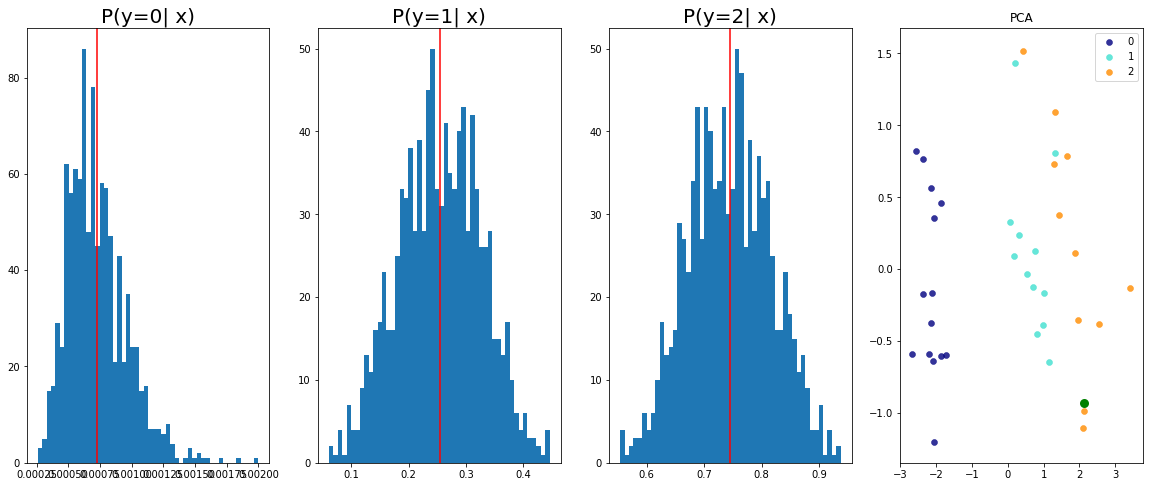

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.05594632774591446


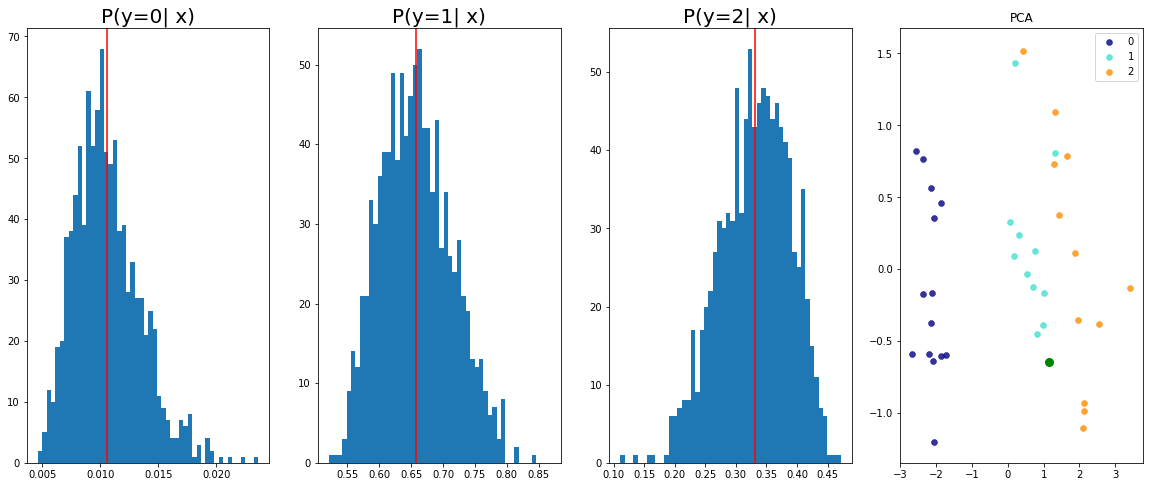

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.06457216292619705


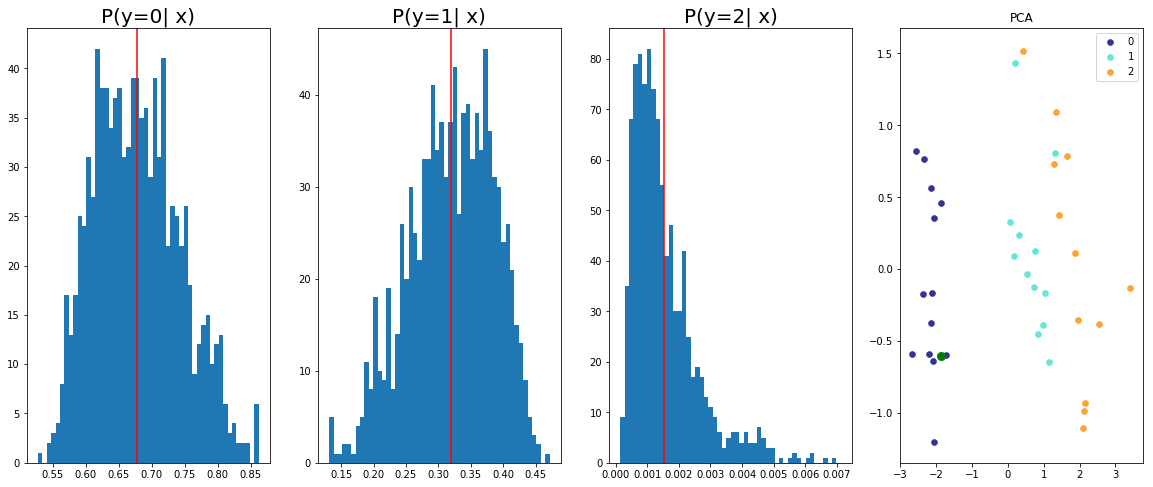

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.05025478079915047


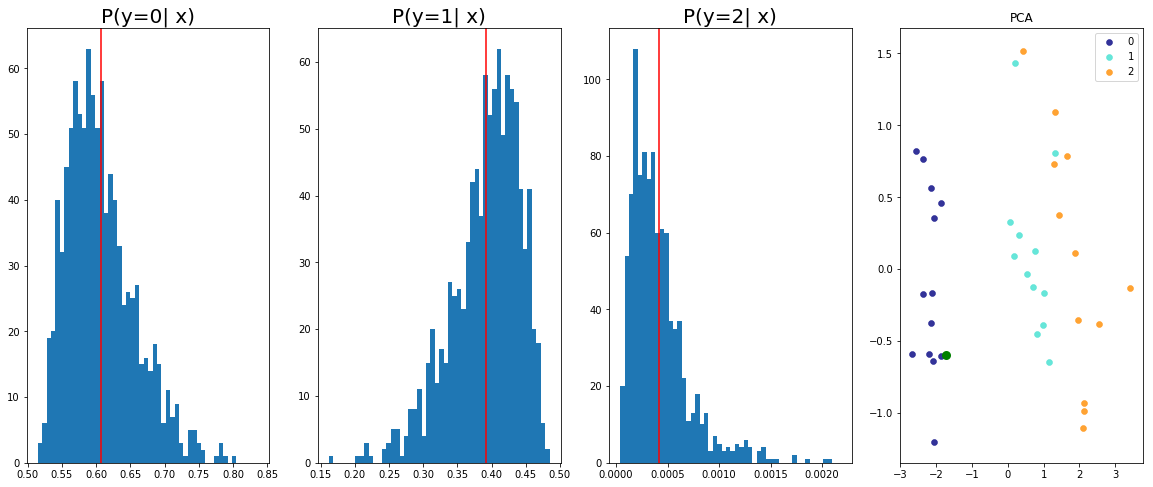

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.03932618722319603


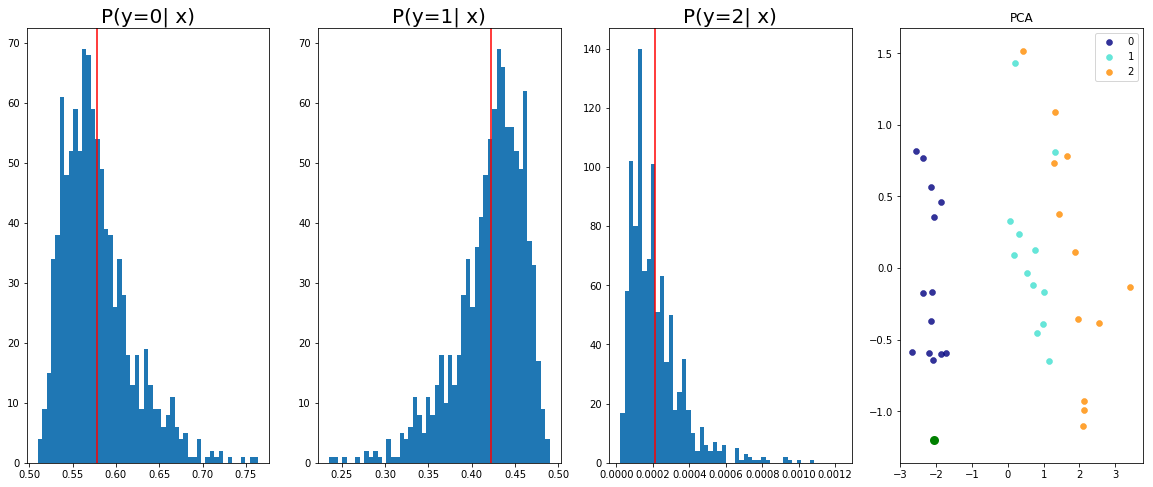

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.03024677000939846


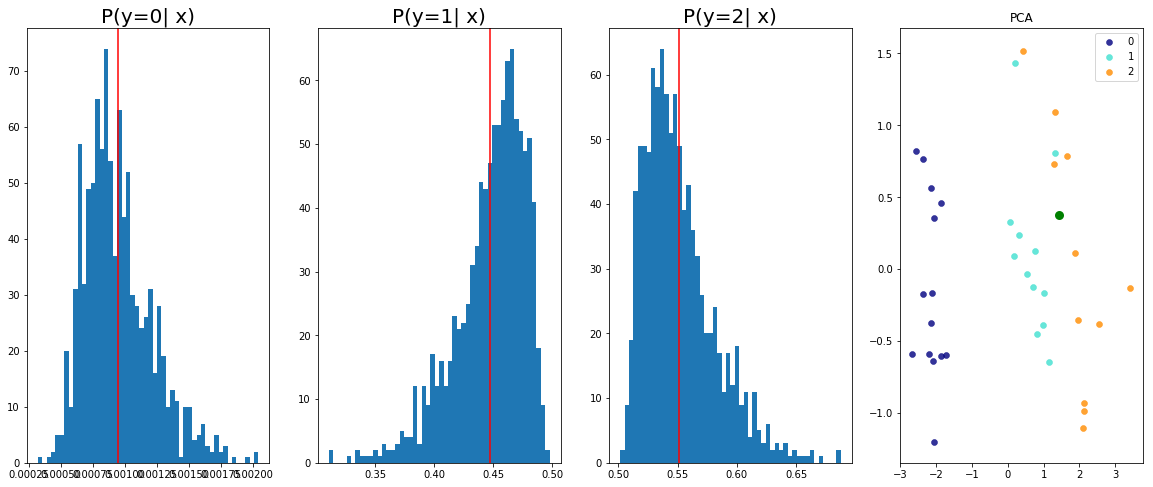

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.05487872660160065


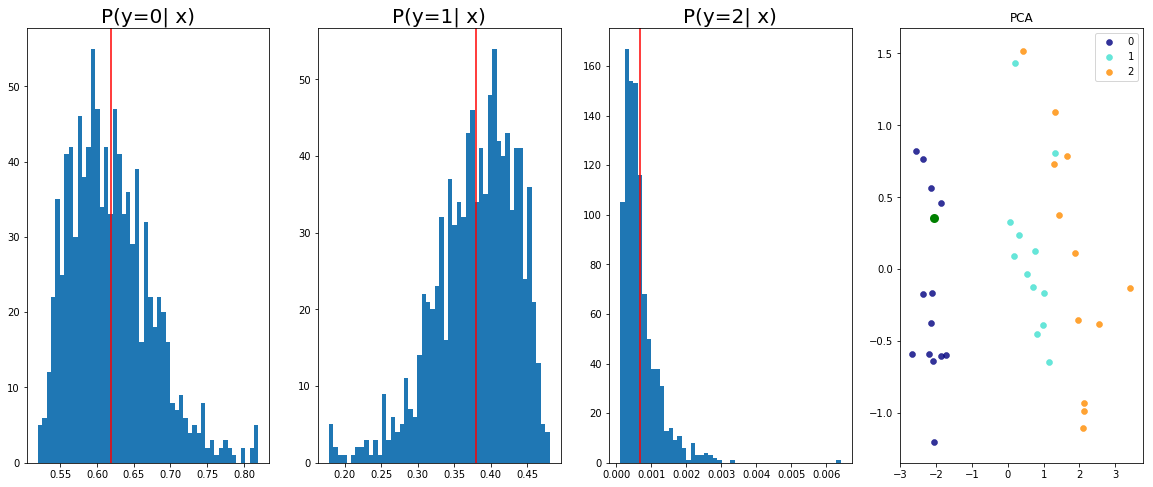

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.07055728137493134


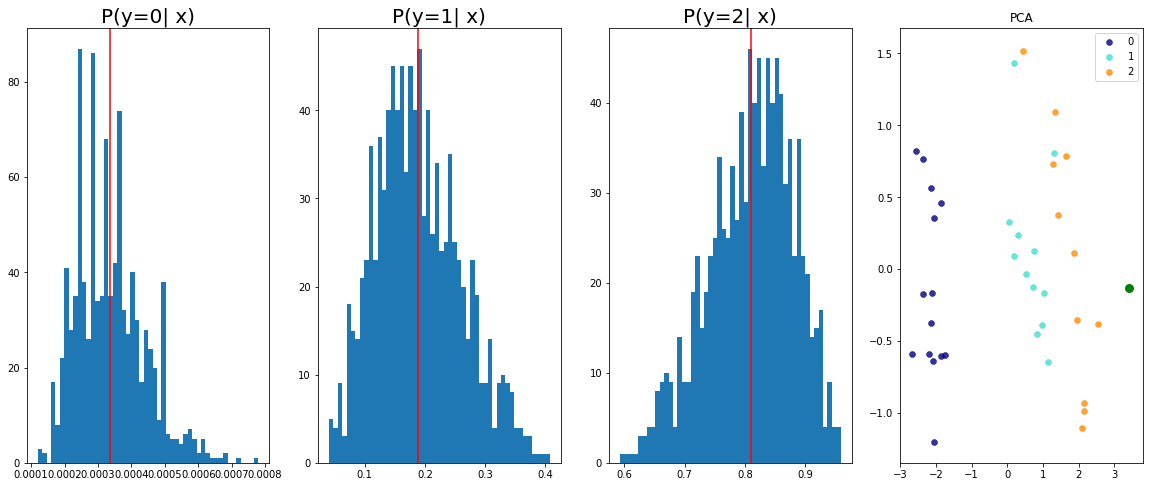

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.044152211397886276


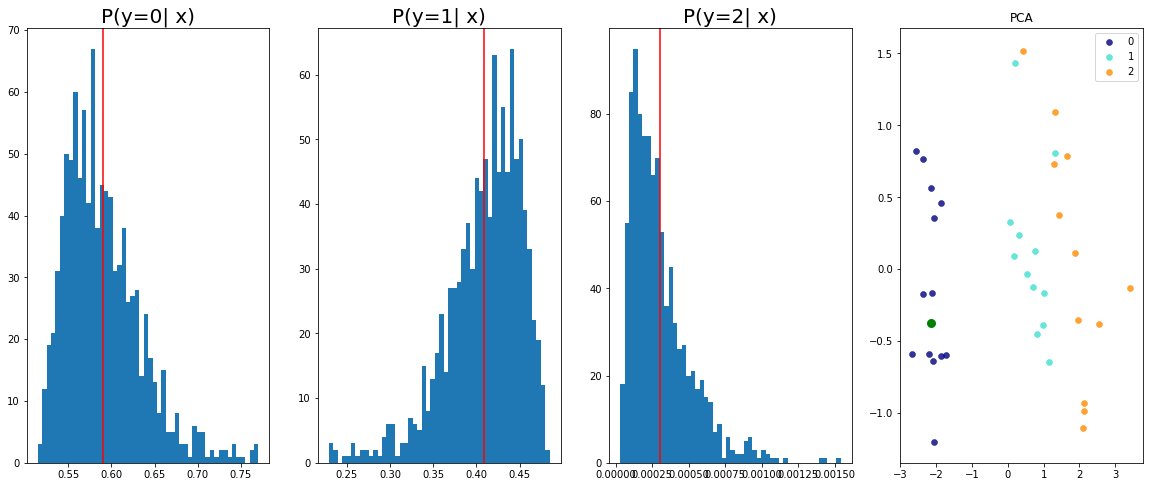

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 2
STDS: 0.023639563471078873


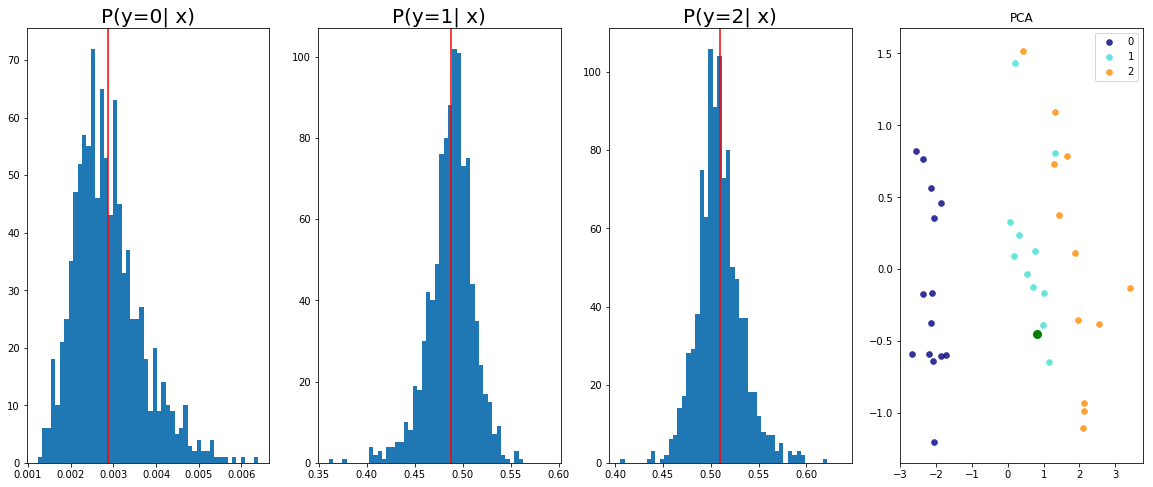

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.02359931915998459


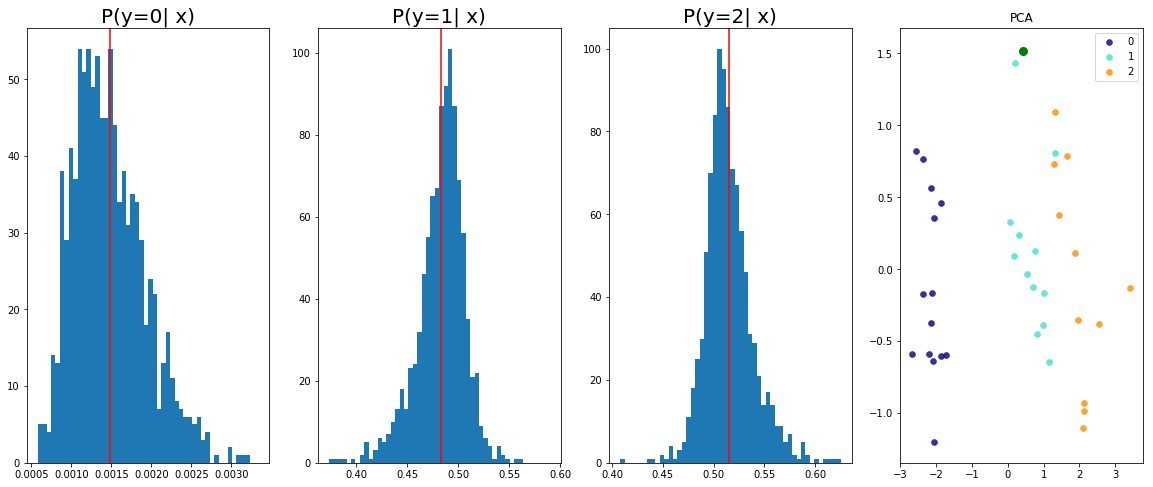

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.04210176691412926


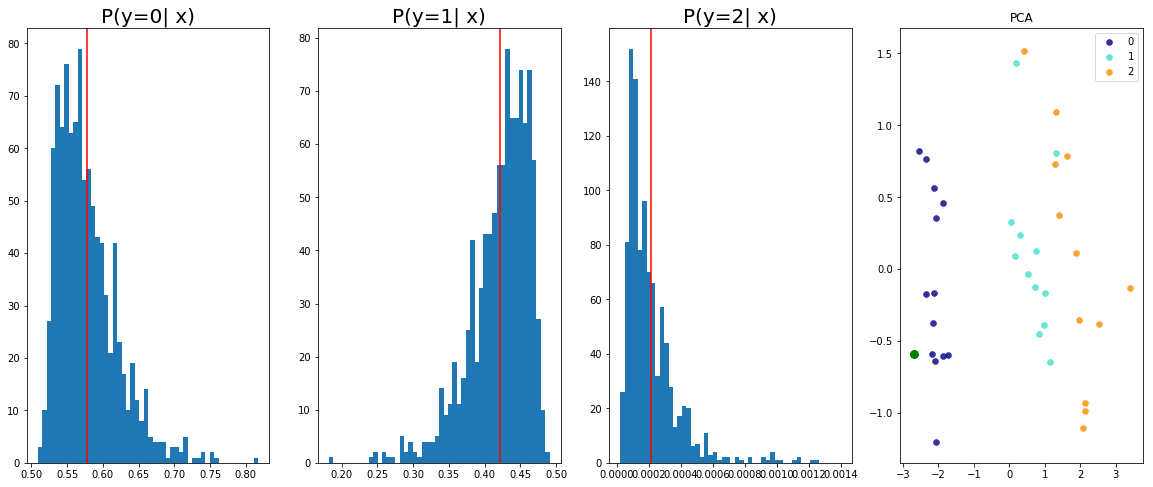

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 1
Predicted -> 1
STDS: 0.05202276259660721


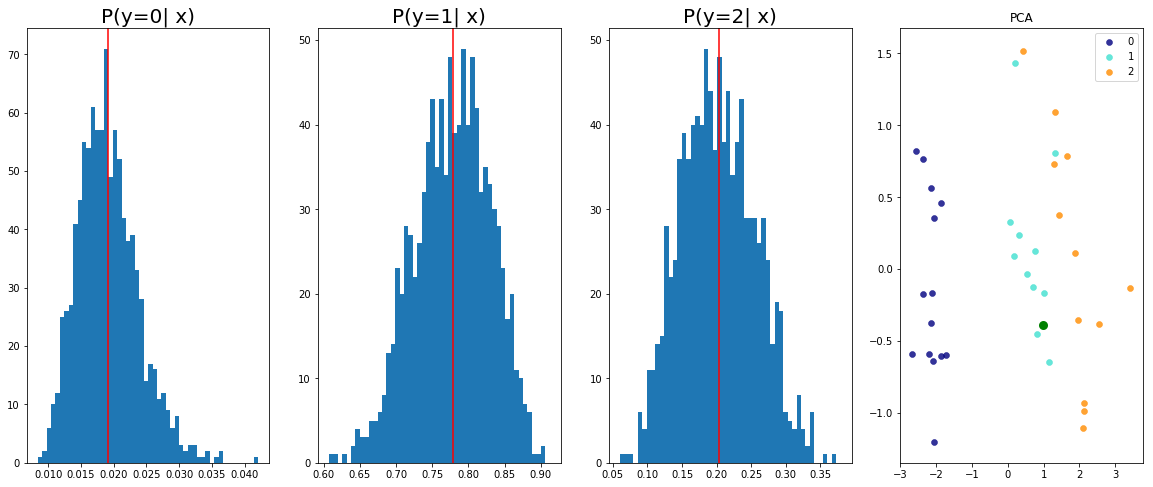

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.033476606011390686


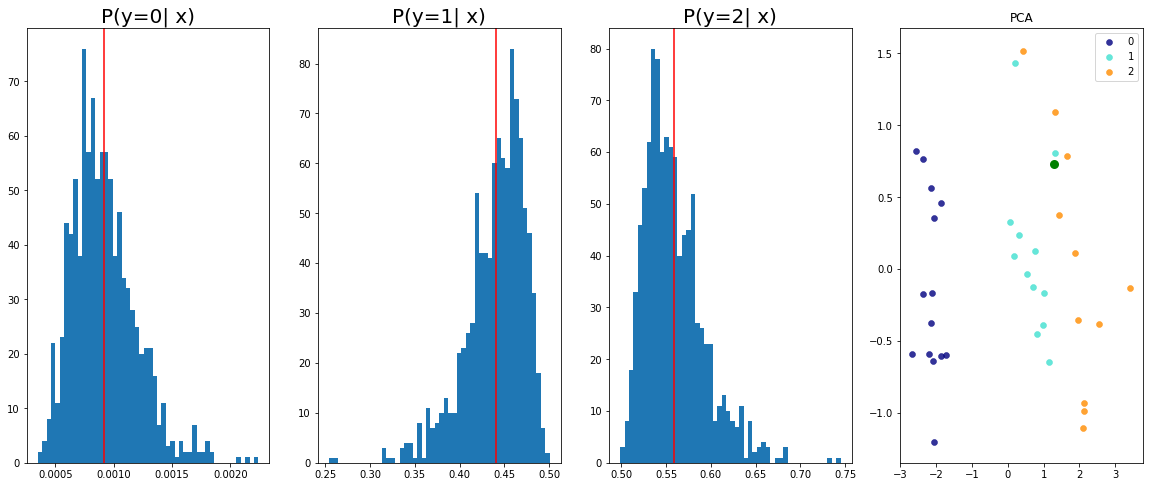

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 0
Predicted -> 0
STDS: 0.0464768260717392


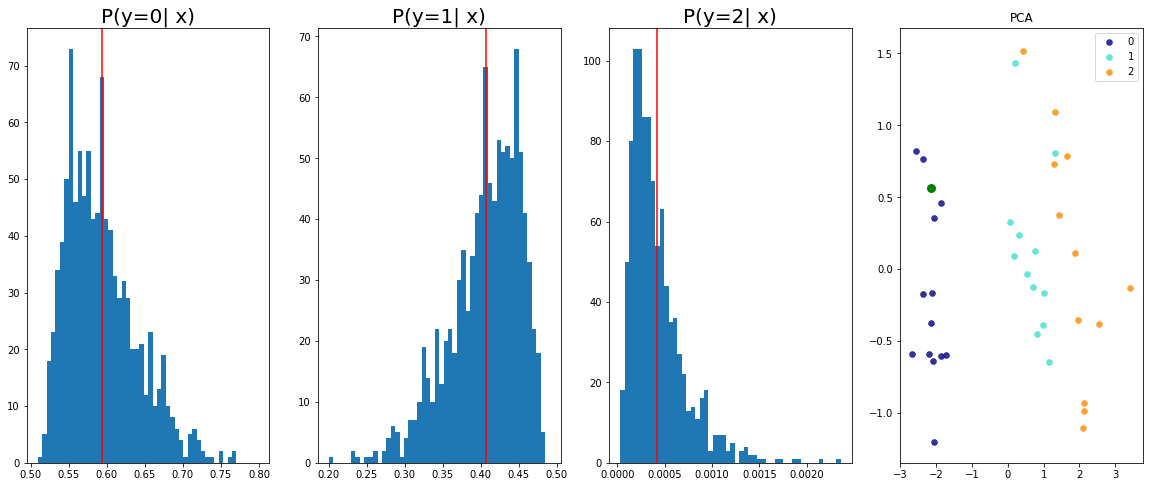

###################################################################################
###################################################################################
###################################################################################
###################################  NAS   ################################################
True -> 2
Predicted -> 2
STDS: 0.06127077341079712


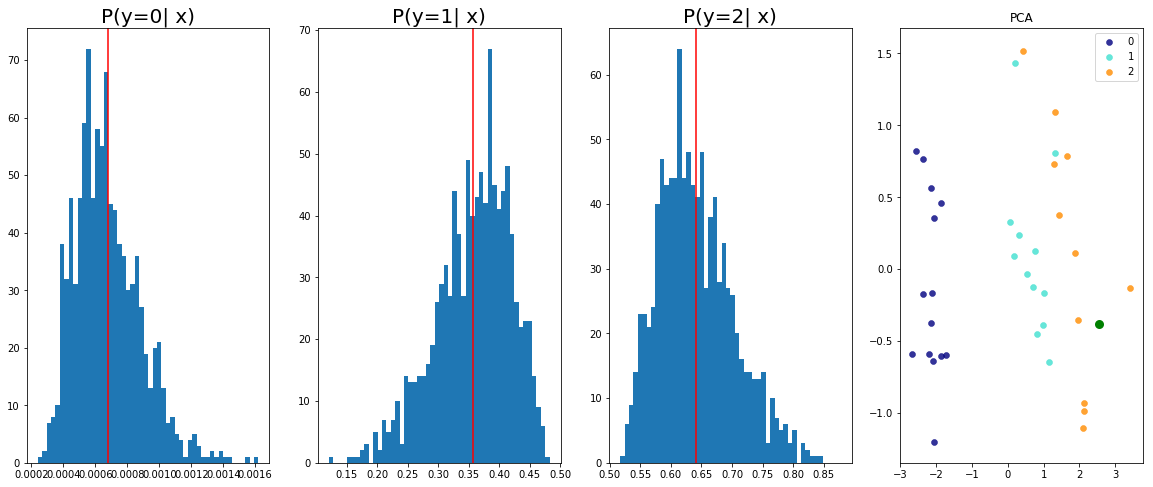

In [27]:
for i in range(len(estimator_nas)):
    print('###################################################################################')
    print('###################################################################################')
    print('###################################################################################')
    print('###################################  NAS   ################################################')
    plot_prediction_probabilities(estimator=estimator_nas, index_to_plot=i)
#     print('###################################  NE   ################################################')
#     plot_prediction_probabilities(estimator=estimator_ne, index_to_plot=i)


In [ ]:
evaluator = EvaluateProbabilisticDL(dataset=estimator_nas.get_dataset(),
                                    batch_size=1000000,
                                    n_samples=config.n_samples,
                                    lr=None,
                                    weight_decay=None,
                                    n_epochs=None,
                                    n_neurons_per_layer=params['n_neurons_per_layer'],
                                    n_hidden_layers=params['n_hidden_layers'],
                                    is_cuda=is_cuda,
                                    beta=config.beta)
evaluator._initialize()
evaluator.best_network = estimator_nas.network
_, y_true, y_pred = evaluator.evaluate()
y_true = y_true.numpy()
y_pred = torch.argmax(y_pred, dim=1).numpy()
accuracy = accuracy_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred, average='weighted')
confusion_m = confusion_matrix(y_true, y_pred)

In [16]:
estimator_nas.results.head()

,example_id,y_pred,y_true,std,range,correct
0,0,6,6,0.022012,0.139266,True
1,1,2,2,0.019502,0.122292,True
2,2,3,3,0.019011,0.153189,True
3,3,7,7,0.015162,0.104022,True
4,4,2,2,0.021044,0.146962,True


In [18]:
std_quantiles = estimator_nas.results[['example_id', 'std']] \
            .sort_values('std', ascending=False) \
            .reset_index(drop=True) \
            .reset_index() \
            .rename(columns={'index': 'order_std'}) \
            .drop(columns='std')
results_enriched = estimator_nas.results.merge(std_quantiles, on='example_id')

results_enriched.head(1)

,example_id,y_pred,y_true,std,range,correct,order_std
0,0,6,6,0.022012,0.139266,True,450


In [15]:
dataset = estimator_nas.get_dataset()

In [16]:
x_batch = dataset.x_train
display(x_batch.mean(0))
display(x_batch.std(0))

tensor([[-0.4242, -0.4242, -0.4242, -0.4241, -0.4241, -0.4238, -0.4232, -0.4228,
         -0.4225, -0.4236, -0.4238, -0.4241, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4241, -0.4229, -0.4201, -0.4081, -0.3866, -0.3638,
         -0.3515, -0.3600, -0.3788, -0.3994, -0.4157, -0.4219, -0.4240, -0.4242],
        [-0.4242, -0.4242, -0.4231, -0.4148, -0.3788, -0.2938, -0.1586, -0.0019,
          0.1247,  0.0944, -0.0549, -0.2136, -0.3396, -0.3971, -0.4199, -0.4239],
        [-0.4242, -0.4238, -0.4132, -0.3711, -0.2380,  0.0192,  0.3735,  0.7253,
          0.9853,  0.9366,  0.6486,  0.2421, -0.1311, -0.3187, -0.4007, -0.4226],
        [-0.4241, -0.4193, -0.3867, -0.2898, -0.0089,  0.4443,  0.8880,  1.1335,
          1.2336,  1.2117,  1.0453,  0.6093,  0.0598, -0.2496, -0.3797, -0.4207],
        [-0.4233, -0.4149, -0.3724, -0.2420,  0.1454,  0.7053,  0.9705,  0.8704,
          0.8211,  0.9370,  0.9829,  0.6336,  0.0844, -0.2467, -0.3882, -0.4209],
        [-0.4237, -0.4

tensor([[0.0000e+00, 0.0000e+00, 2.9395e-04, 9.5532e-03, 1.2746e-02, 1.6503e-02,
         2.7744e-02, 3.4088e-02, 4.0159e-02, 1.7945e-02, 1.9077e-02, 1.2055e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.3759e-03, 4.3786e-02, 6.3421e-02, 1.3433e-01,
         2.1841e-01, 2.8242e-01, 3.1746e-01, 2.8454e-01, 2.3530e-01, 1.7910e-01,
         1.0544e-01, 4.1180e-02, 1.1517e-02, 2.9395e-03],
        [1.4697e-04, 4.6469e-04, 1.9659e-02, 9.0352e-02, 2.4614e-01, 4.2935e-01,
         6.1568e-01, 7.6603e-01, 8.4312e-01, 7.9487e-01, 6.7627e-01, 5.3360e-01,
         3.3323e-01, 1.6363e-01, 5.4858e-02, 1.3421e-02],
        [5.8789e-04, 1.2472e-02, 1.1107e-01, 3.0064e-01, 5.7515e-01, 8.5036e-01,
         1.0729e+00, 1.2073e+00, 1.2421e+00, 1.2062e+00, 1.1575e+00, 1.0241e+00,
         7.2357e-01, 4.0963e-01, 1.6721e-01, 3.4719e-02],
        [5.5567e-03, 7.0419e-02, 2.3962e-01, 4.9428e-01, 8.3698e-01, 1.0783e+00,
         1.1782e+00, 1.2223e+00, 1.2256

In [17]:
x_batch.shape

torch.Size([7500, 16, 16])

In [20]:
report = experiment_data_ne.reports['7aba913e-7d4d-4611-be93-9549c2d0389e']

In [21]:
config = jsons.load(report.configuration, BaseConfiguration)
network = ProbabilisticFeedForwardDeser.from_dict(report.best_network)
network

ProbabilisticFeedForward(
  (activation): Tanh()
  (layer_1): ComplexStochasticLinear (4 -> 10)
  (activation_1): Tanh()
  (layer_0): StochasticLinear (10 -> 3)
)

In [26]:
config.dataset_random_state = 1

In [27]:
estimator = PredictionDistributionEstimatorNetwork(network, config=config, testing=False, n_samples=1000)\
                .estimate()\
                .enrich_with_dispersion_quantile()\
                .calculate_metrics_by_dispersion_quantile()

Sum Train: -6.481589317321777
Training: 112. Testing: 38


,order_std,accuracy,f1
0,10,0.980198,0.980003
1,11,0.980000,0.979803
2,12,0.979798,0.979599
3,13,0.979592,0.979371
4,14,0.979381,0.979136
...,...,...,...
87,97,1.000000,1.000000
88,98,1.000000,1.000000
89,99,1.000000,1.000000
90,100,1.000000,1.000000


,order_std,accuracy,f1
0,10,0.980198,0.980003
1,11,0.980000,0.979803
2,12,0.979798,0.979599
3,13,0.979592,0.979371
4,14,0.979381,0.979136


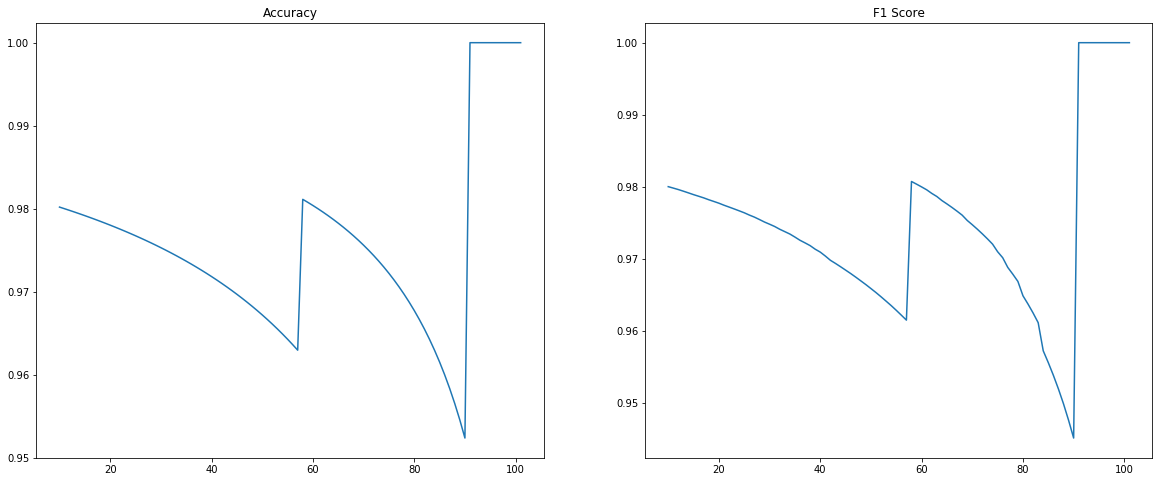

In [29]:
display(estimator.metrics_by_quantile.head())
plot_metrics_by_quantile(metrics_by_quantile=estimator.metrics_by_quantile)

True -> 1
Predicted -> 1
STDS: 0.13165701925754547


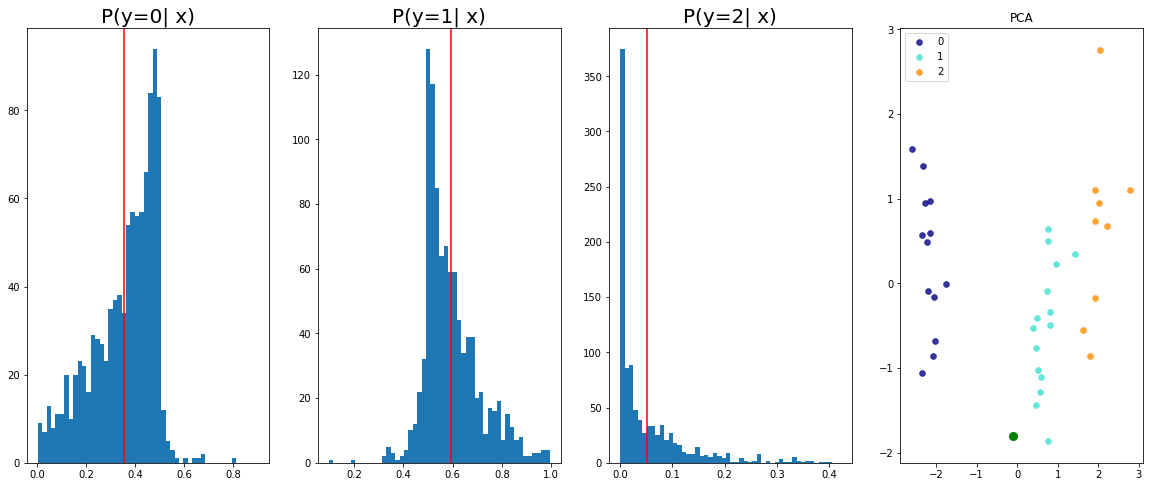

In [28]:
plot_prediction_probabilities(estimator=estimator, index_to_plot=1)

True -> 0
Predicted -> 0
STDS: 0.07055343687534332


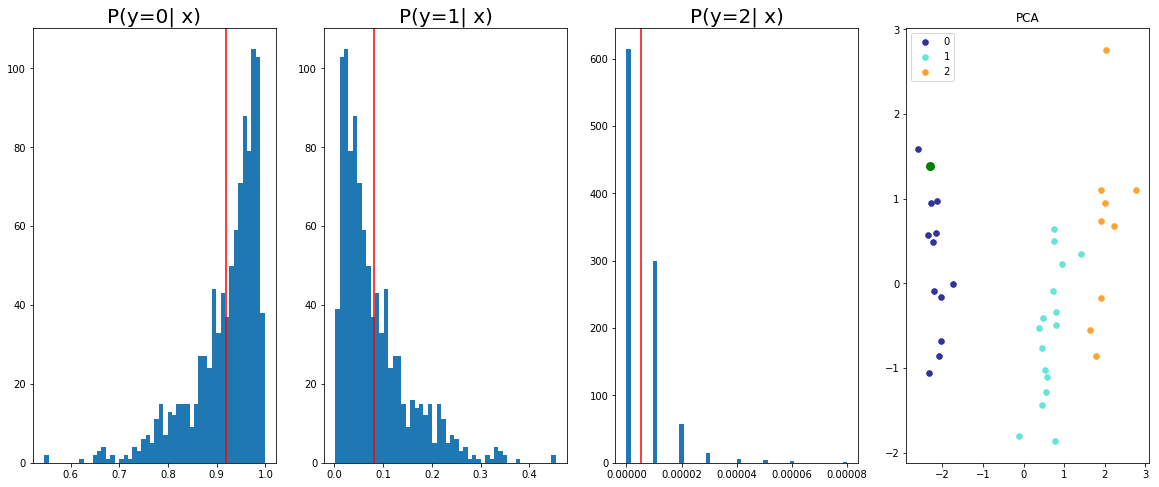

True -> 1
Predicted -> 1
STDS: 0.13165701925754547


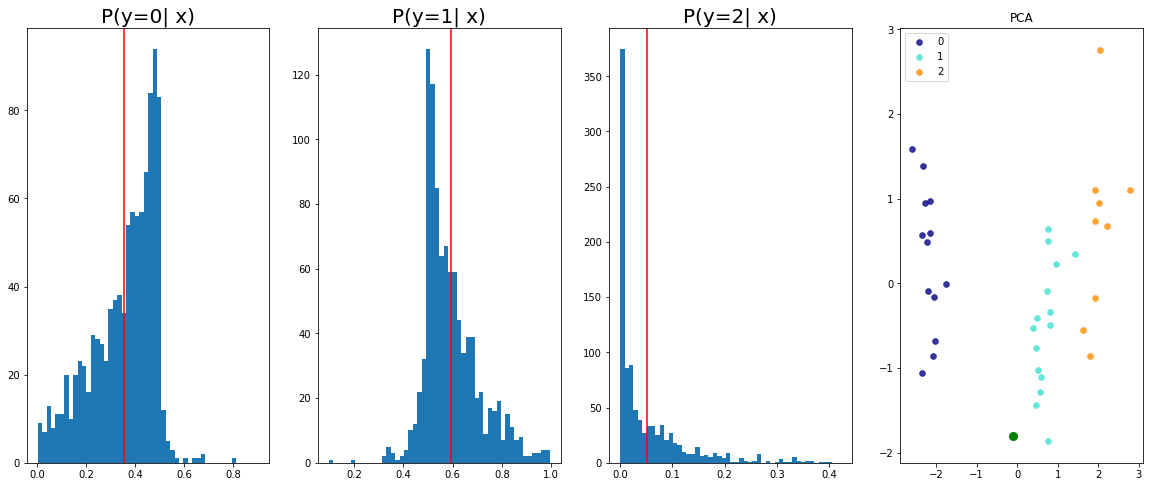

True -> 1
Predicted -> 1
STDS: 0.15950532257556915


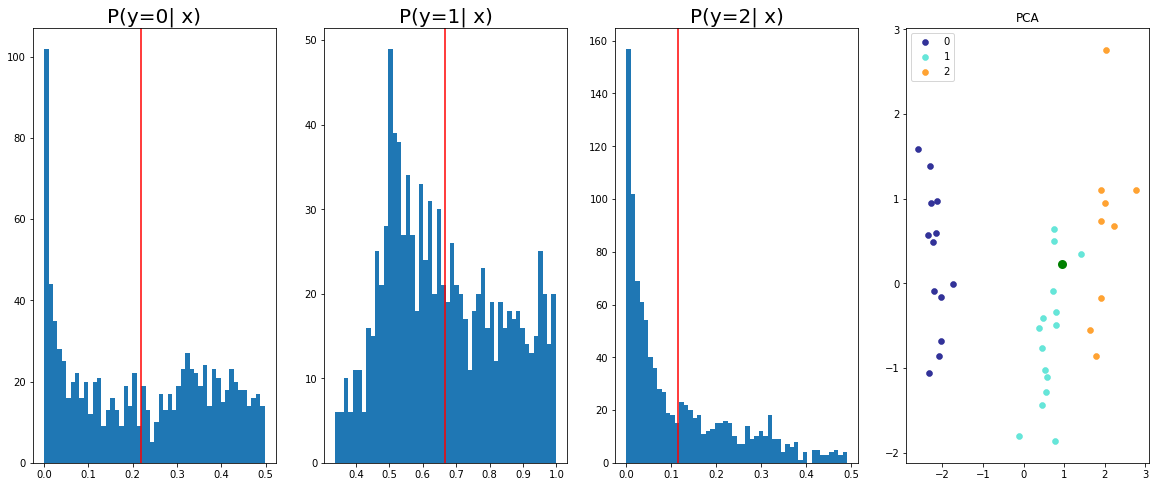

True -> 0
Predicted -> 0
STDS: 0.07272834330797195


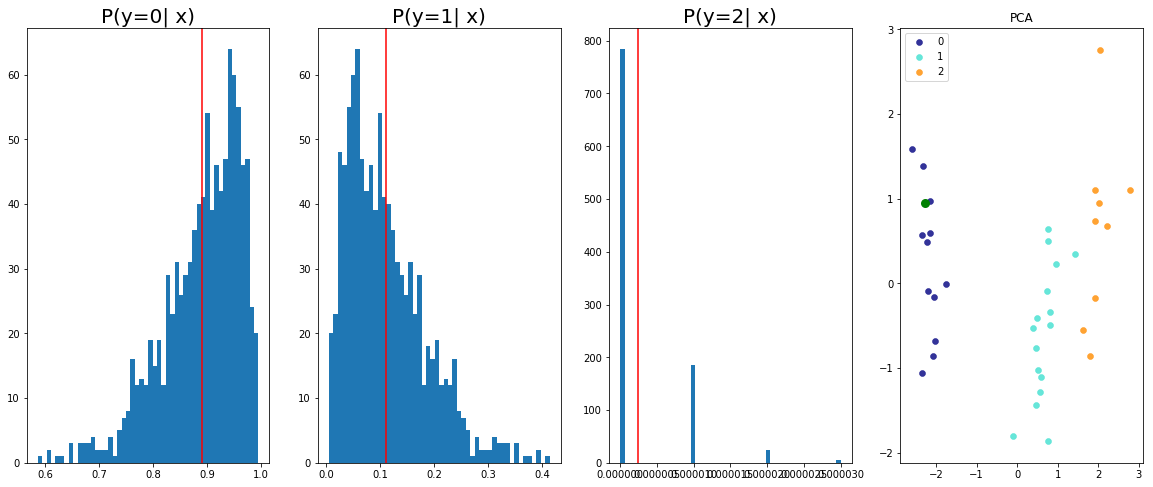

True -> 2
Predicted -> 2
STDS: 0.03955630585551262


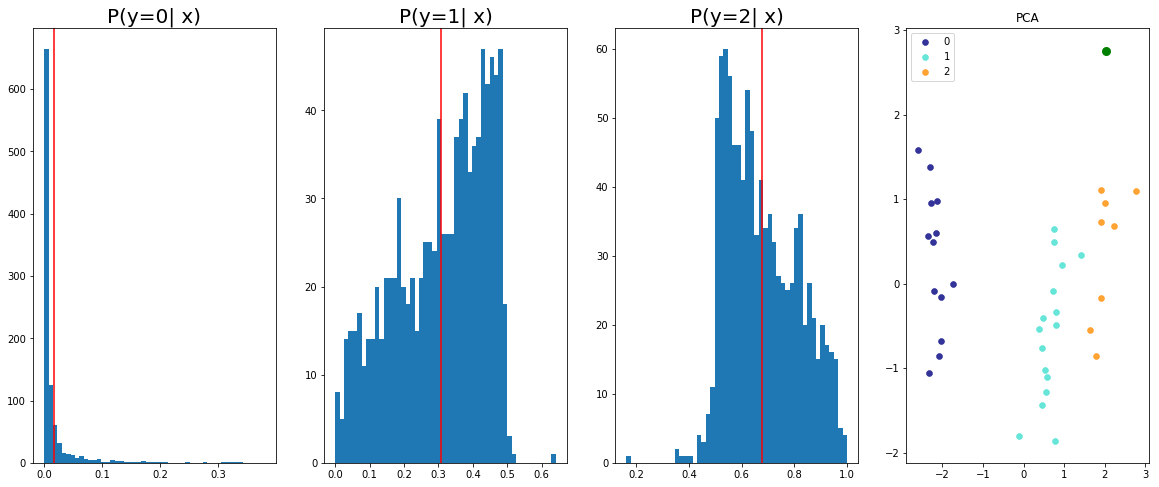

True -> 1
Predicted -> 1
STDS: 0.10696055740118027


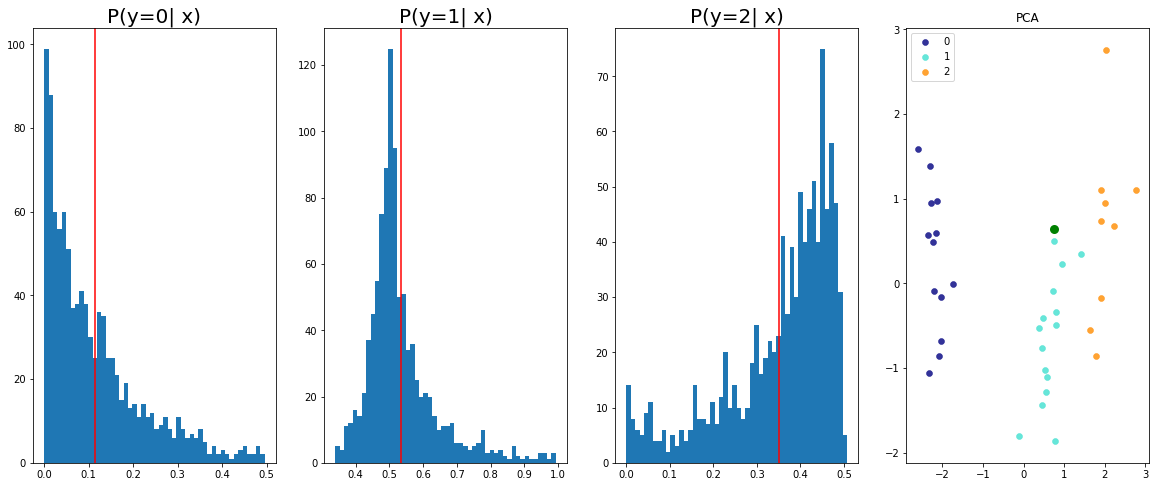

True -> 2
Predicted -> 2
STDS: 0.07213427871465683


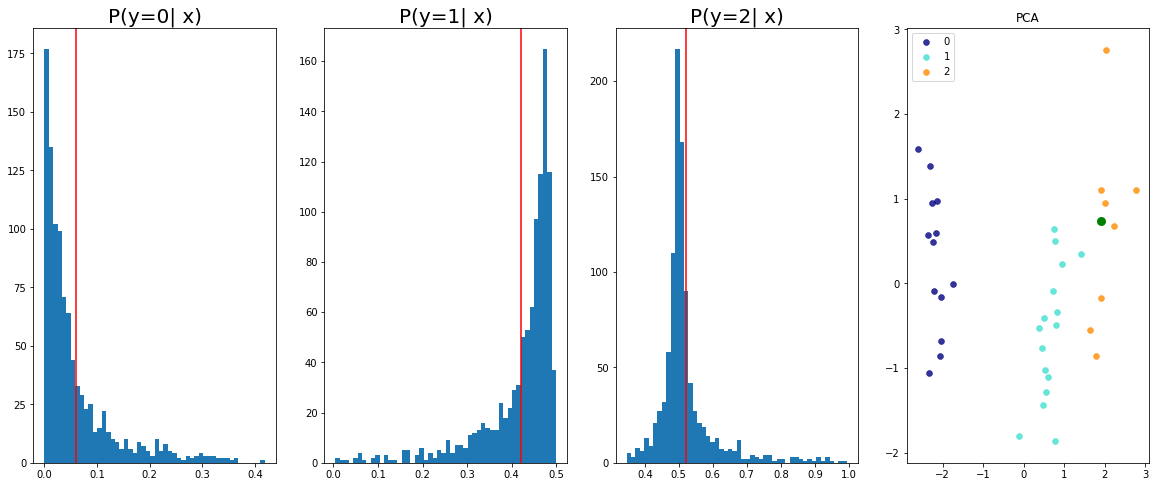

True -> 0
Predicted -> 0
STDS: 0.07141809910535812


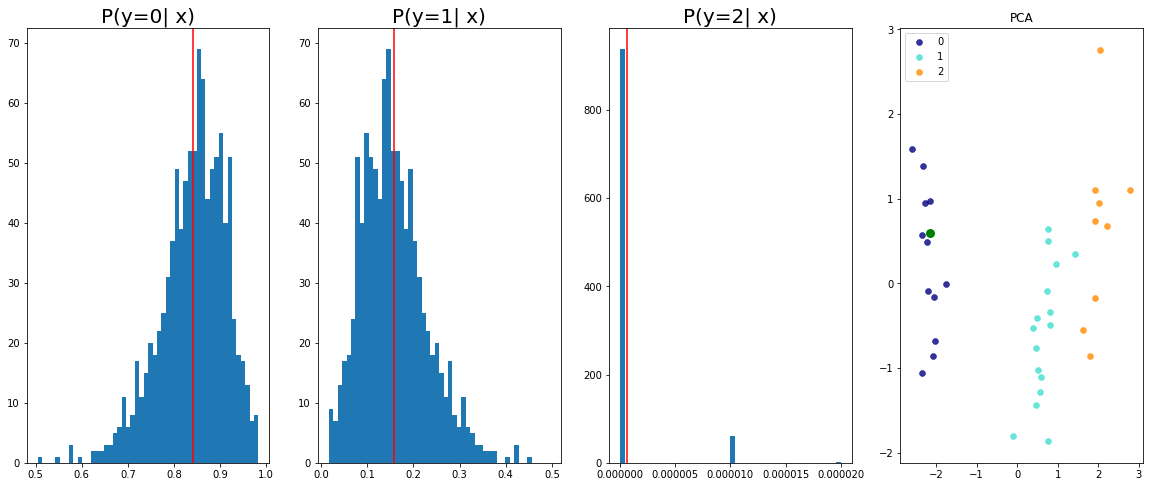

True -> 0
Predicted -> 0
STDS: 0.09987819194793701


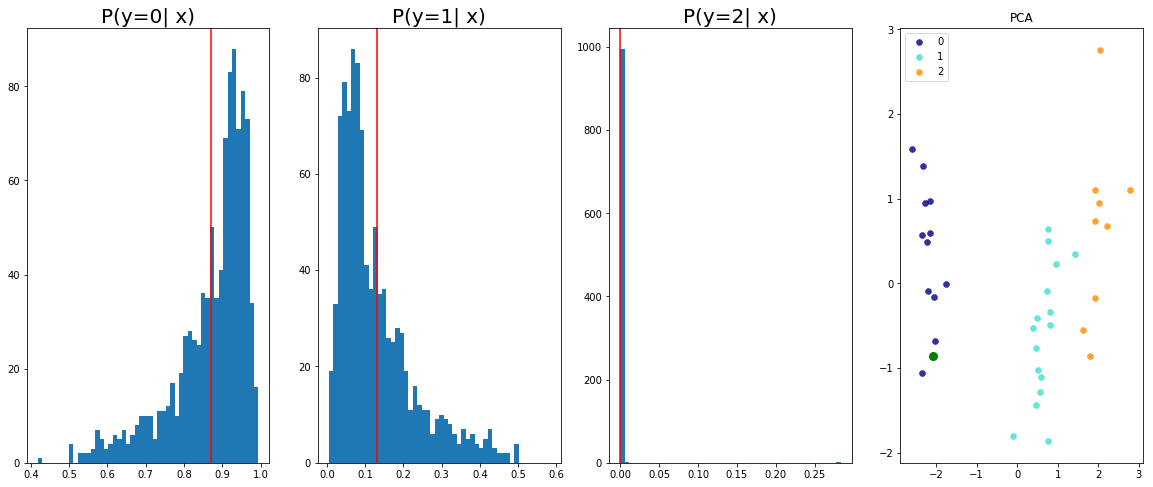

True -> 2
Predicted -> 2
STDS: 0.05386827886104584


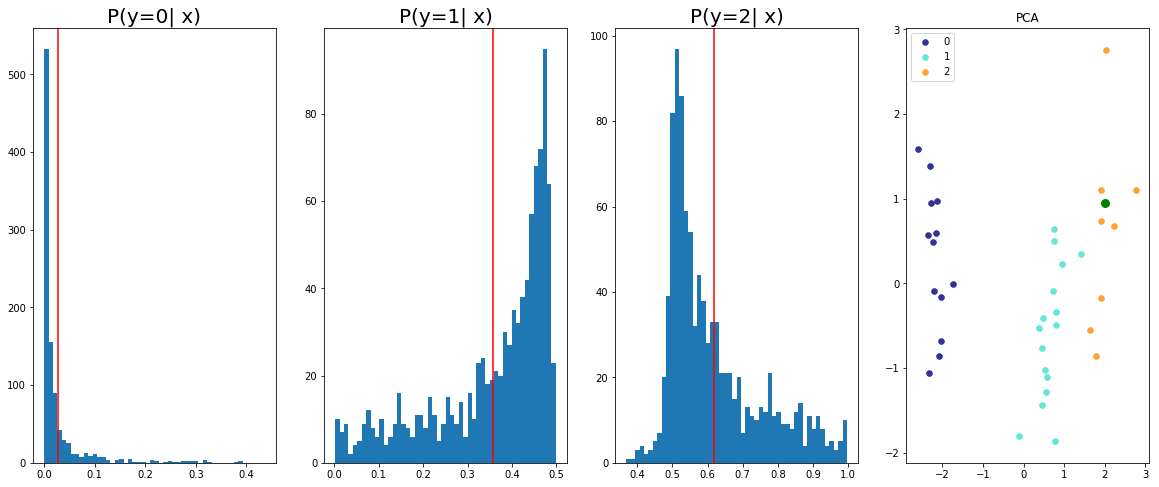

True -> 1
Predicted -> 1
STDS: 0.08846960216760635


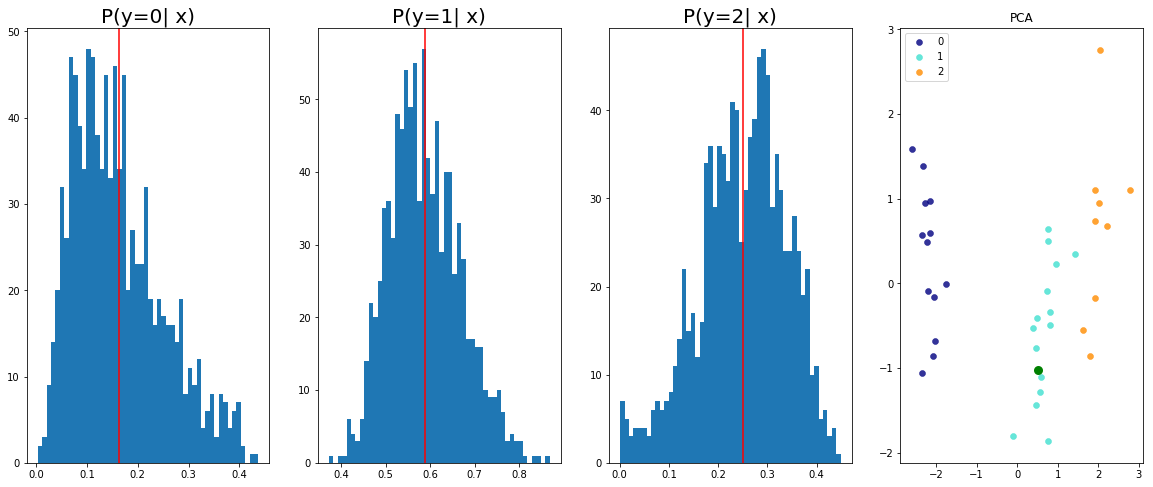

True -> 0
Predicted -> 0
STDS: 0.07483415305614471


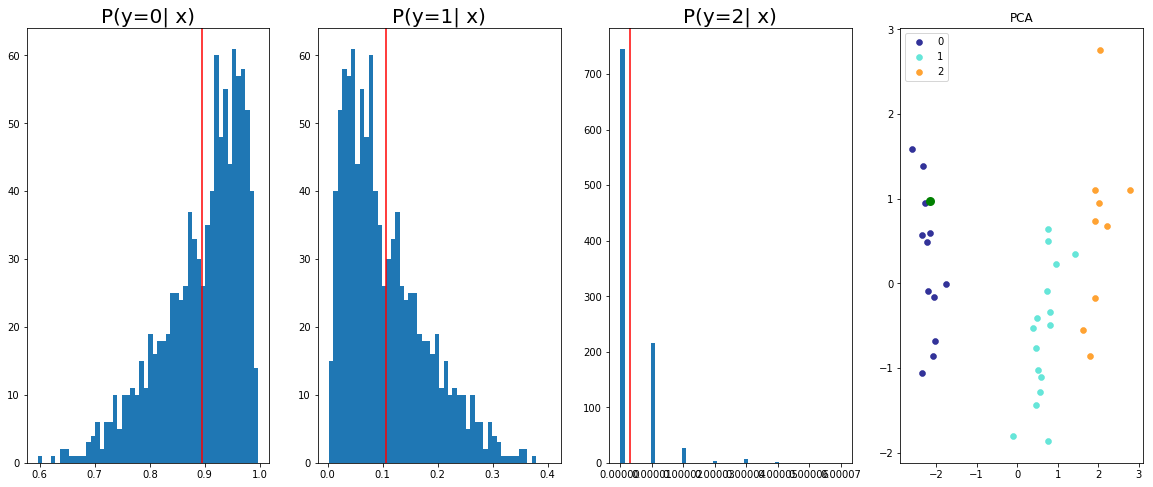

True -> 2
Predicted -> 2
STDS: 0.034651387482881546


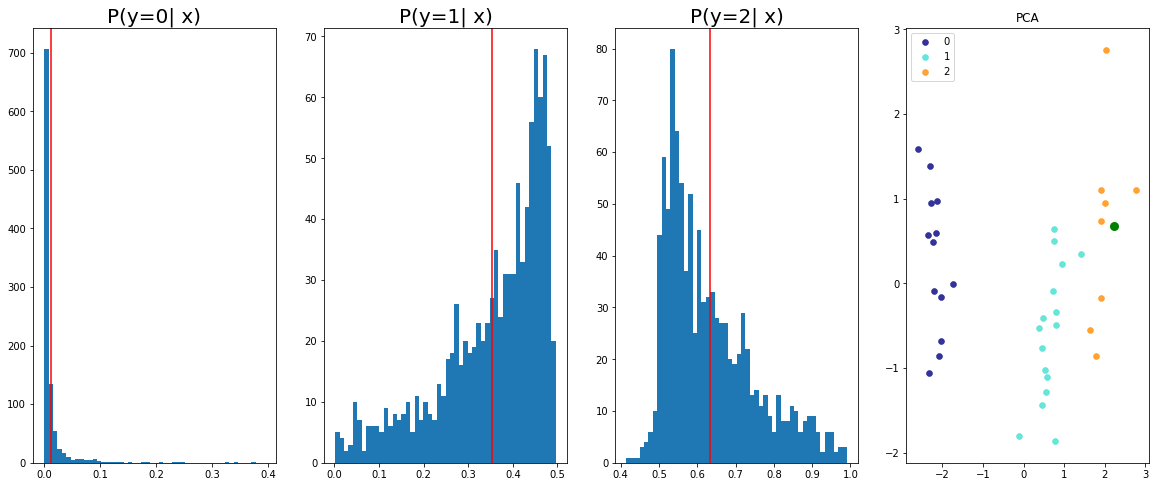

True -> 1
Predicted -> 1
STDS: 0.1401941478252411


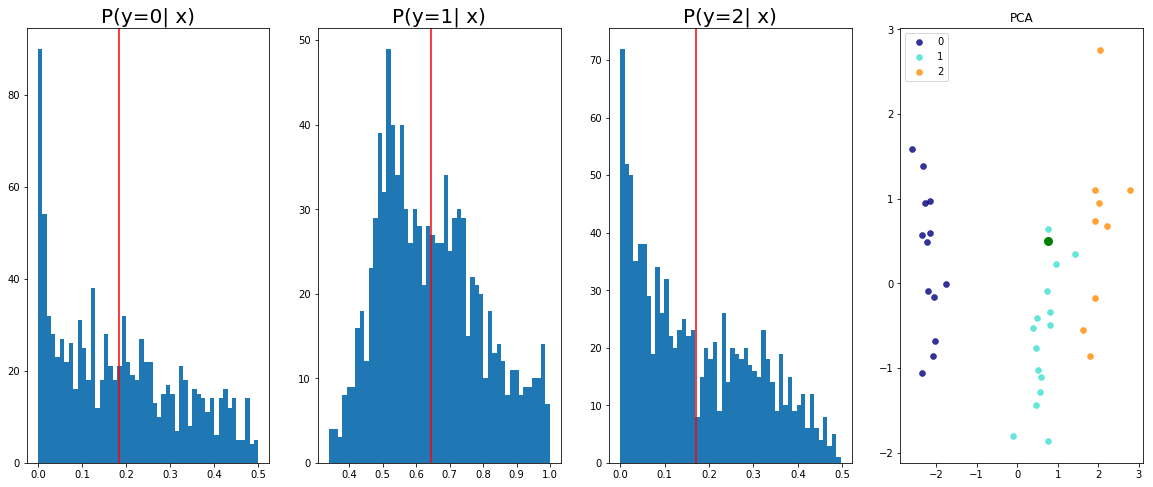

True -> 1
Predicted -> 1
STDS: 0.06242700666189194


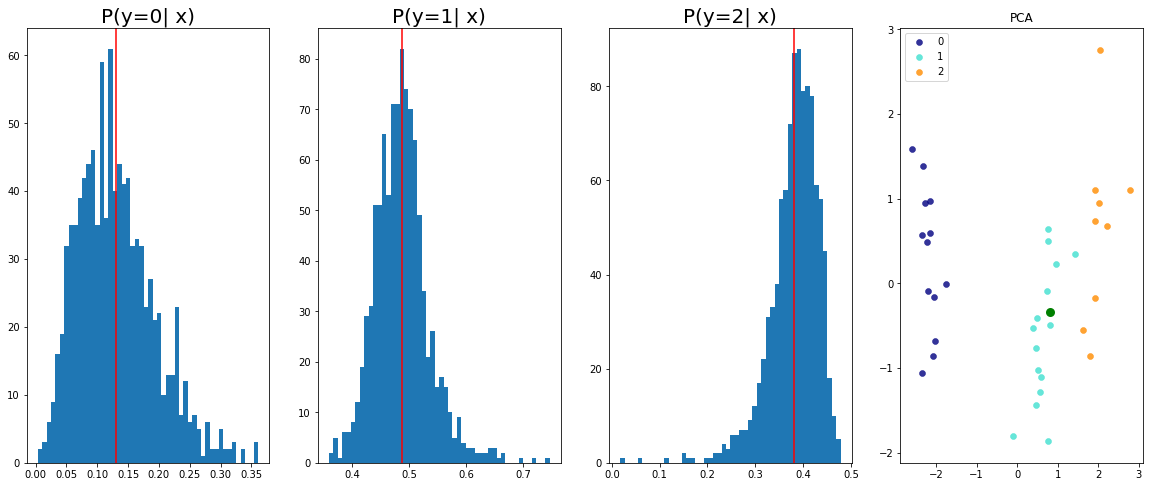

True -> 0
Predicted -> 0
STDS: 0.10543514788150787


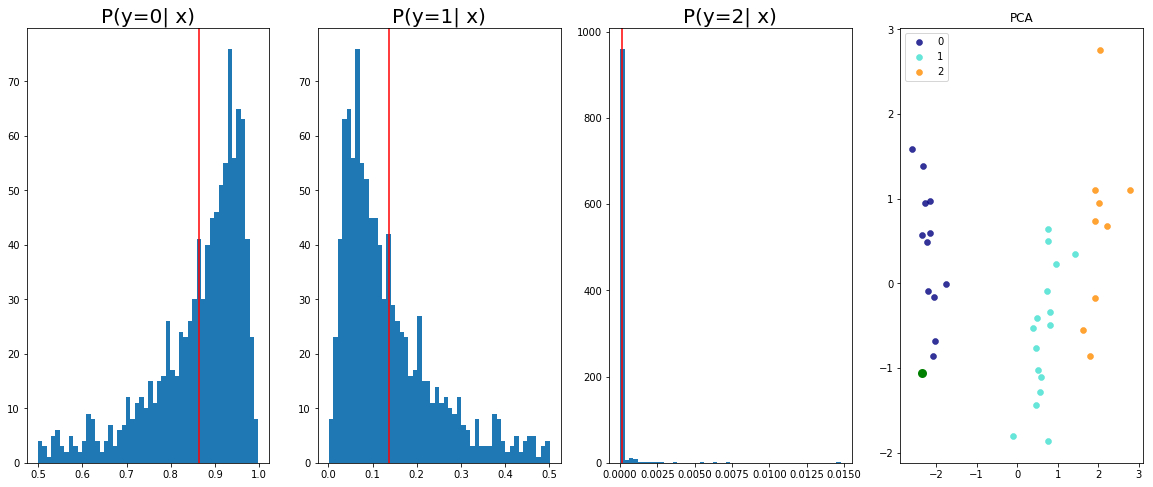

True -> 1
Predicted -> 1
STDS: 0.09375502914190292


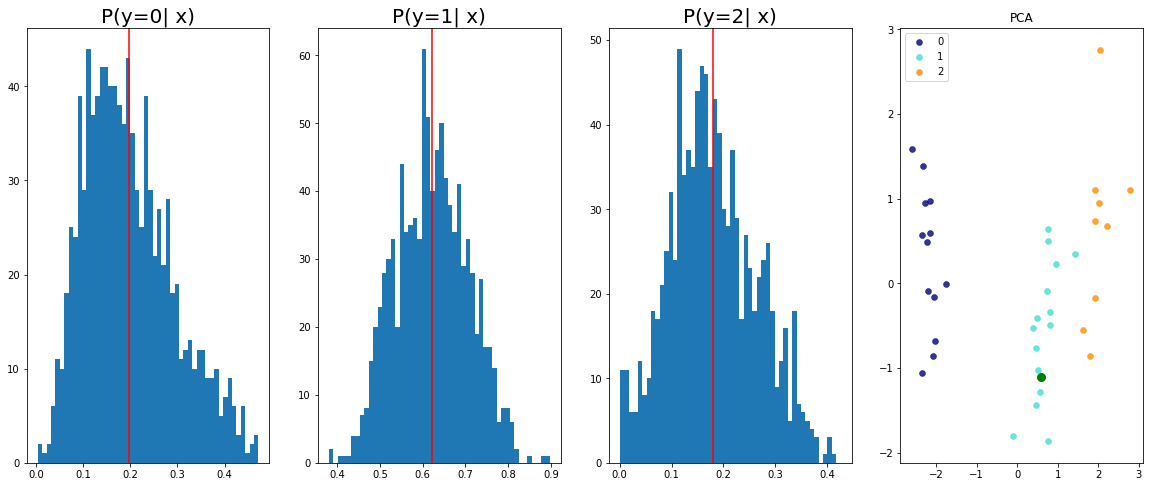

True -> 1
Predicted -> 1
STDS: 0.07412047684192657


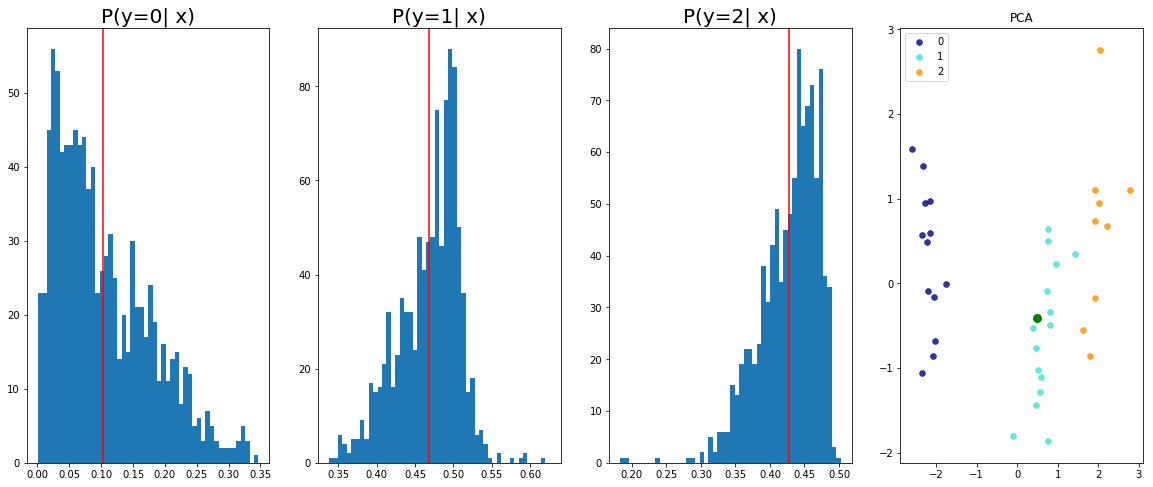

True -> 0
Predicted -> 0
STDS: 0.06351975351572037


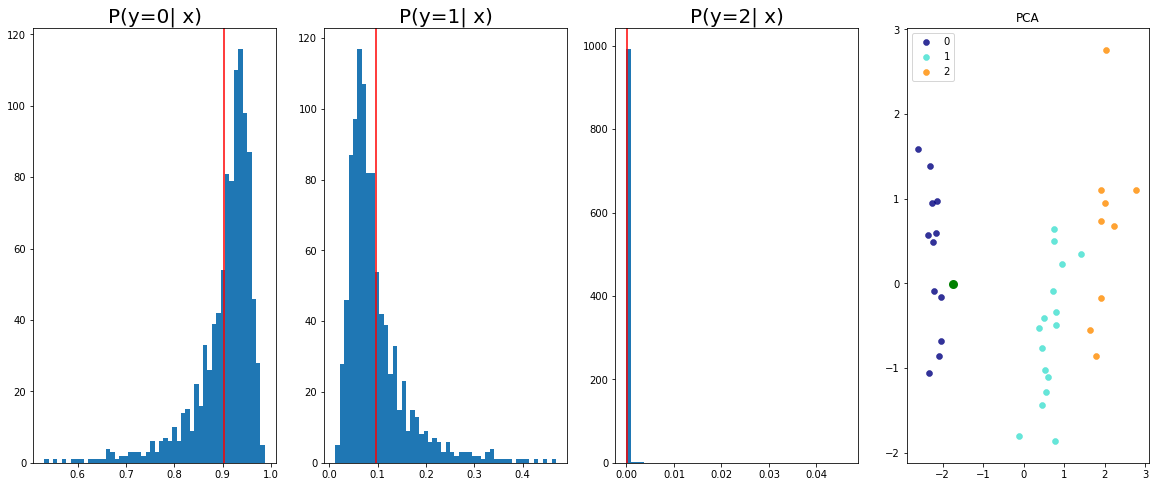

True -> 0
Predicted -> 0
STDS: 0.09610296785831451


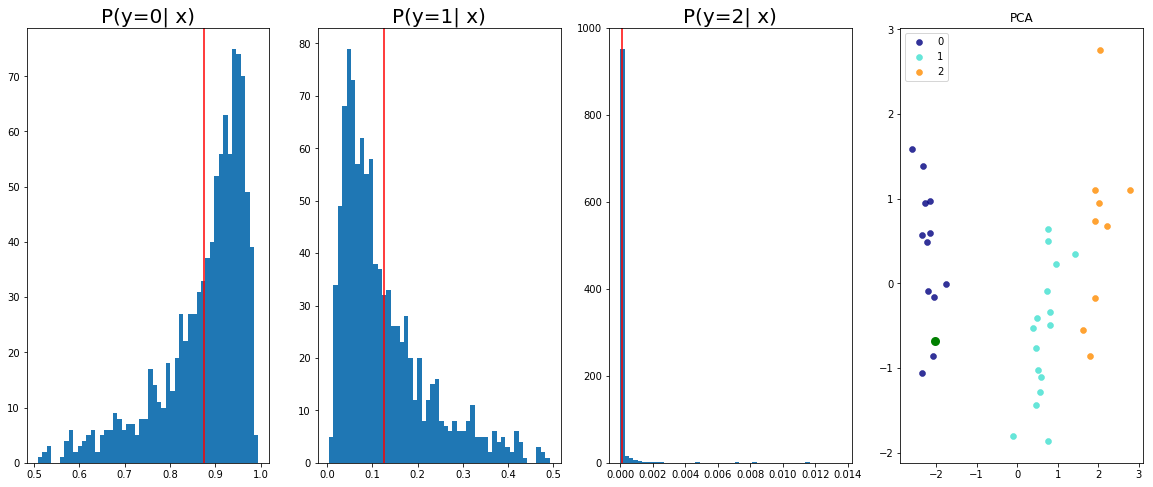

True -> 1
Predicted -> 1
STDS: 0.08926736563444138


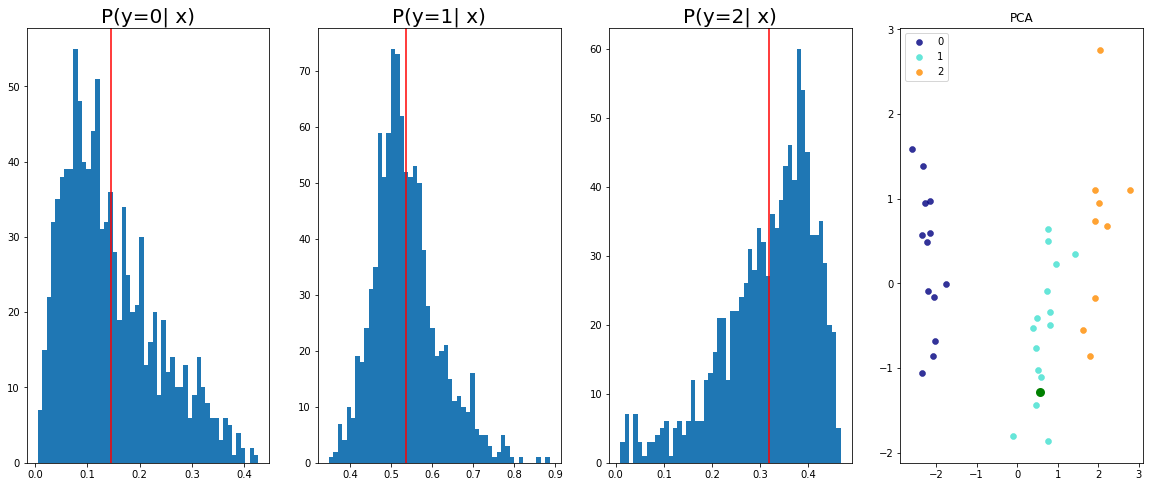

True -> 1
Predicted -> 1
STDS: 0.08073766529560089


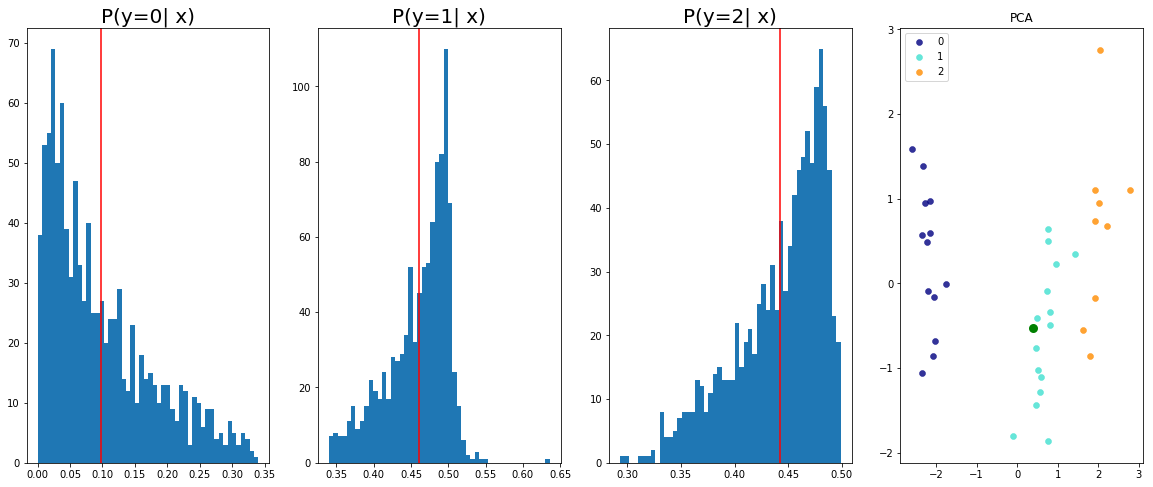

True -> 1
Predicted -> 1
STDS: 0.07359510660171509


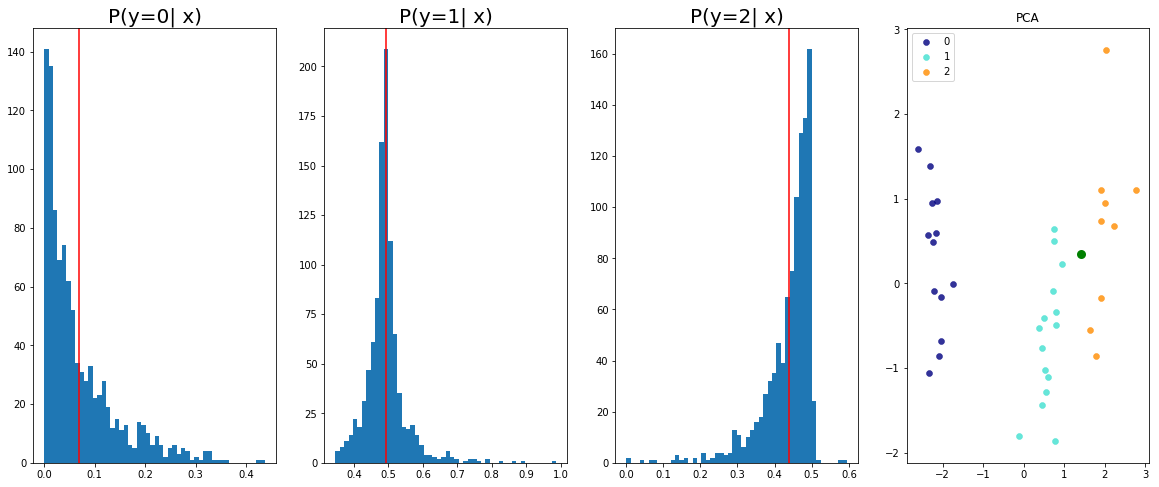

True -> 0
Predicted -> 0
STDS: 0.0665154904127121


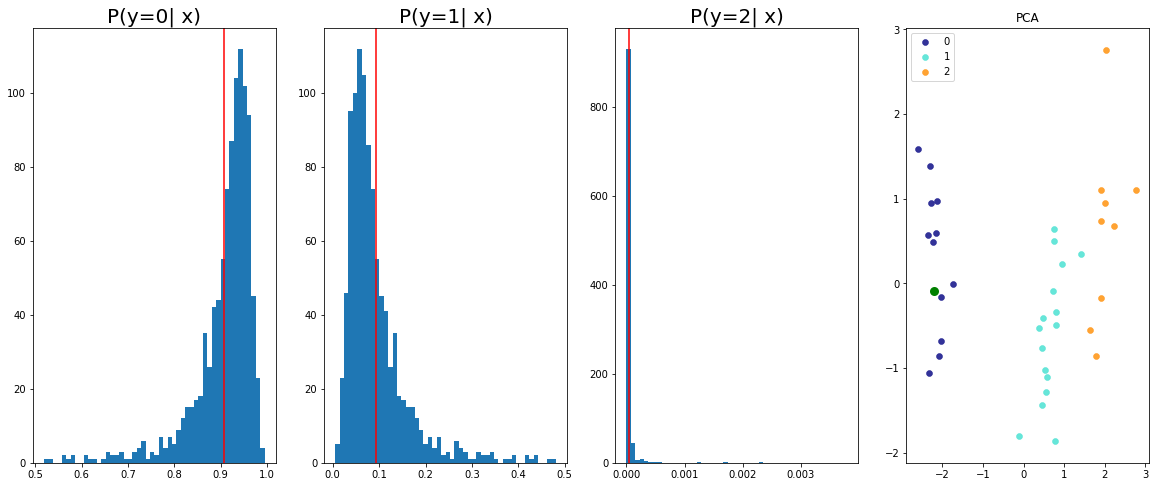

True -> 2
Predicted -> 2
STDS: 0.02820996753871441


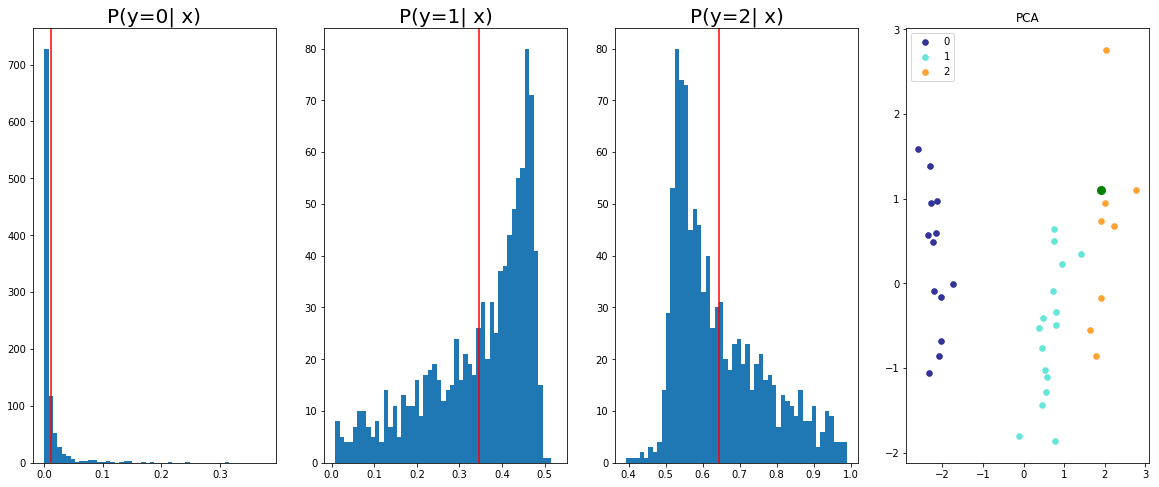

True -> 1
Predicted -> 1
STDS: 0.08391118049621582


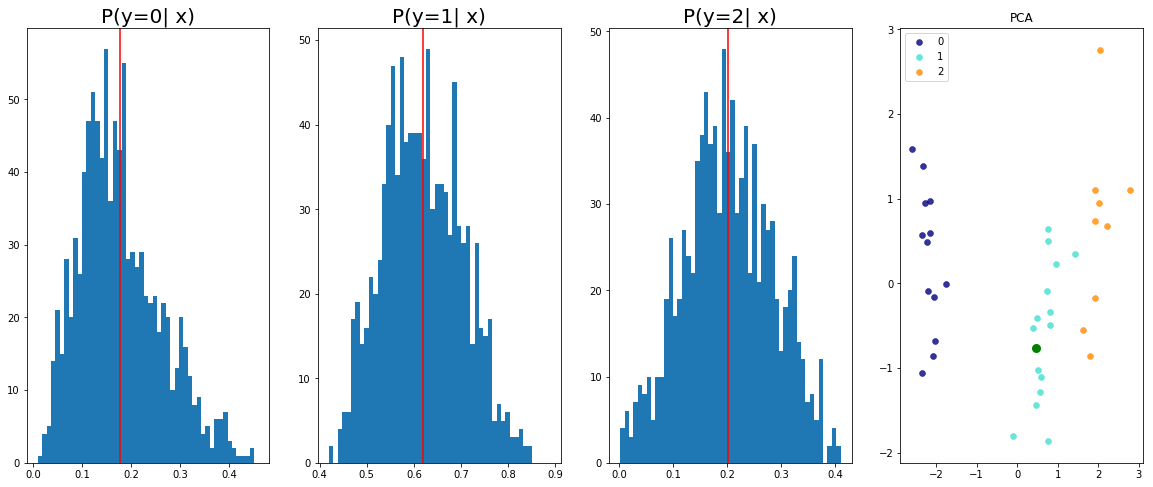

True -> 0
Predicted -> 0
STDS: 0.0746115893125534


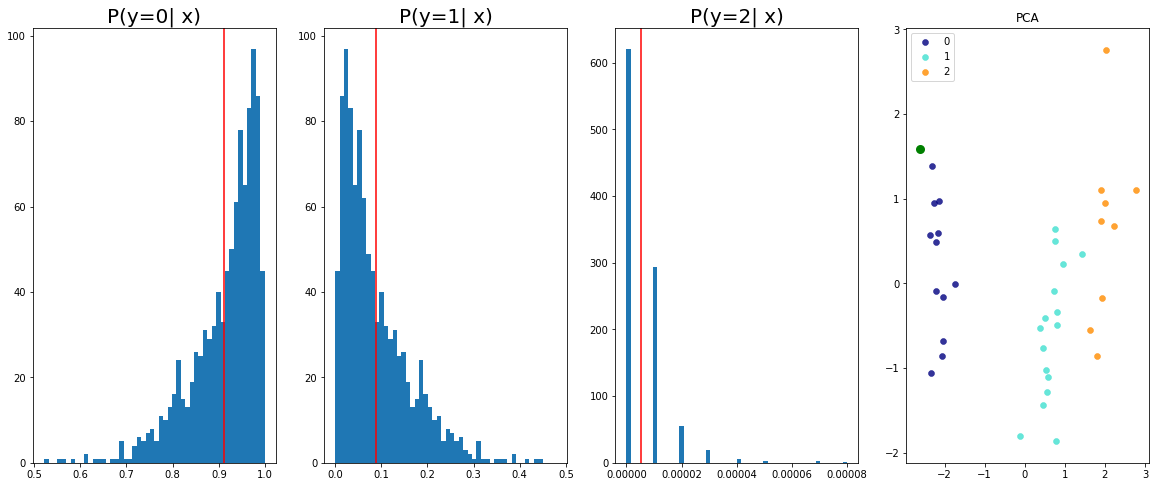

True -> 0
Predicted -> 0
STDS: 0.07384000718593597


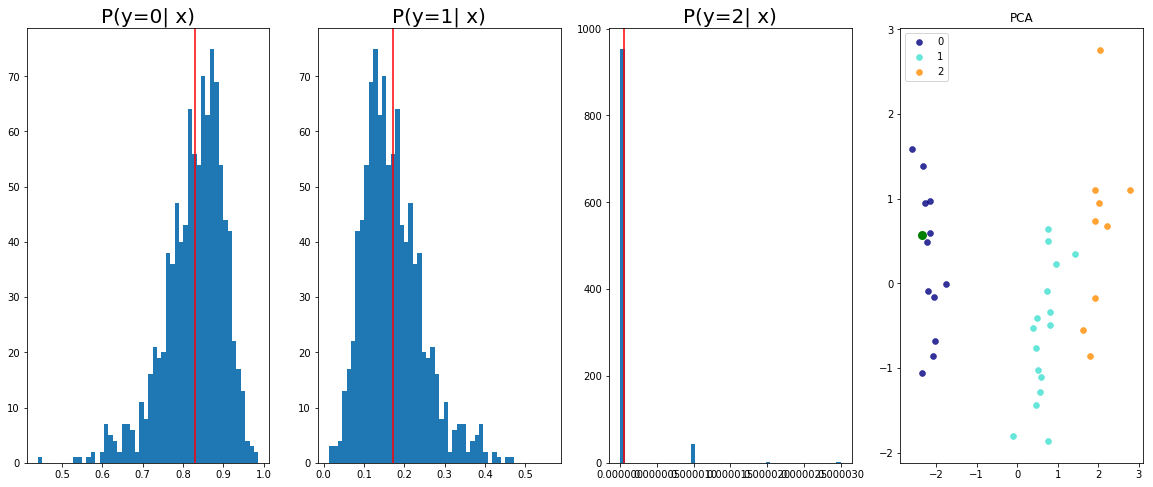

True -> 1
Predicted -> 1
STDS: 0.07461754232645035


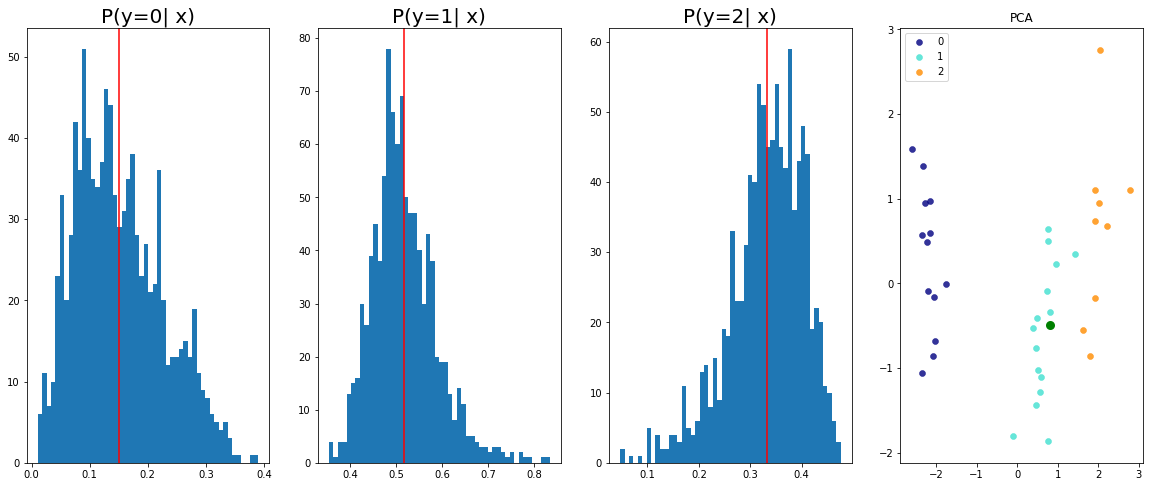

True -> 2
Predicted -> 2
STDS: 0.0608082041144371


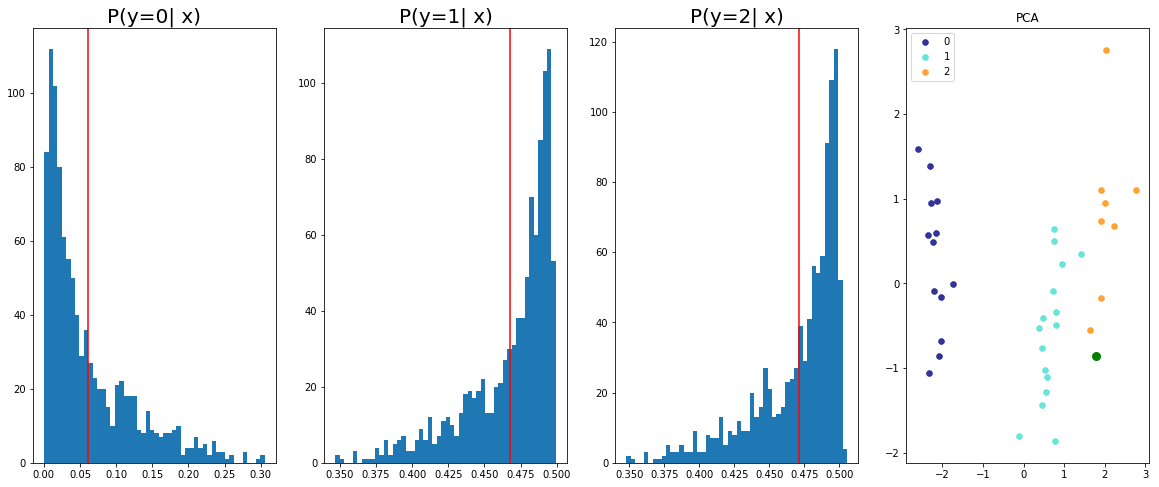

True -> 1
Predicted -> 1
STDS: 0.09363450109958649


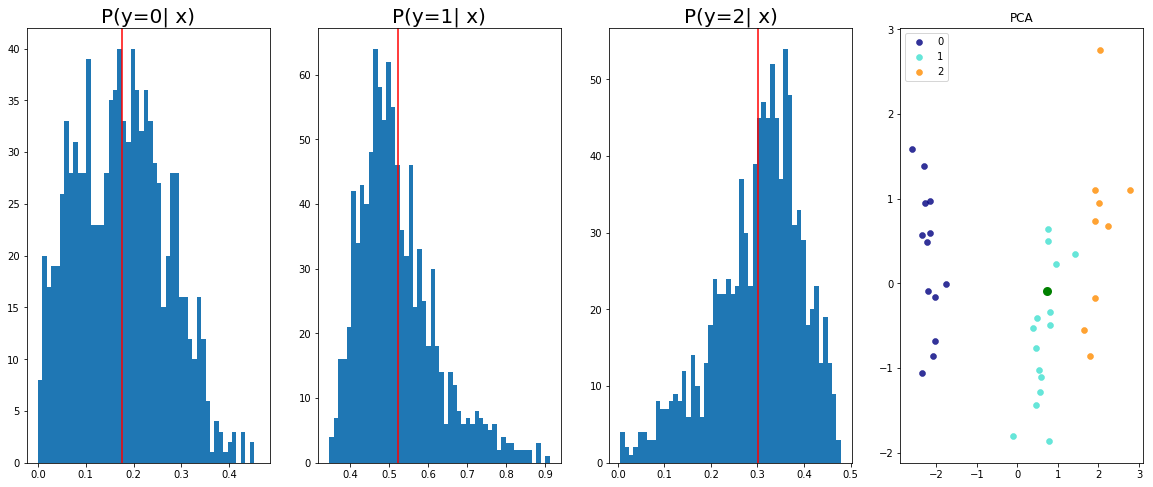

True -> 2
Predicted -> 2
STDS: 0.03468935191631317


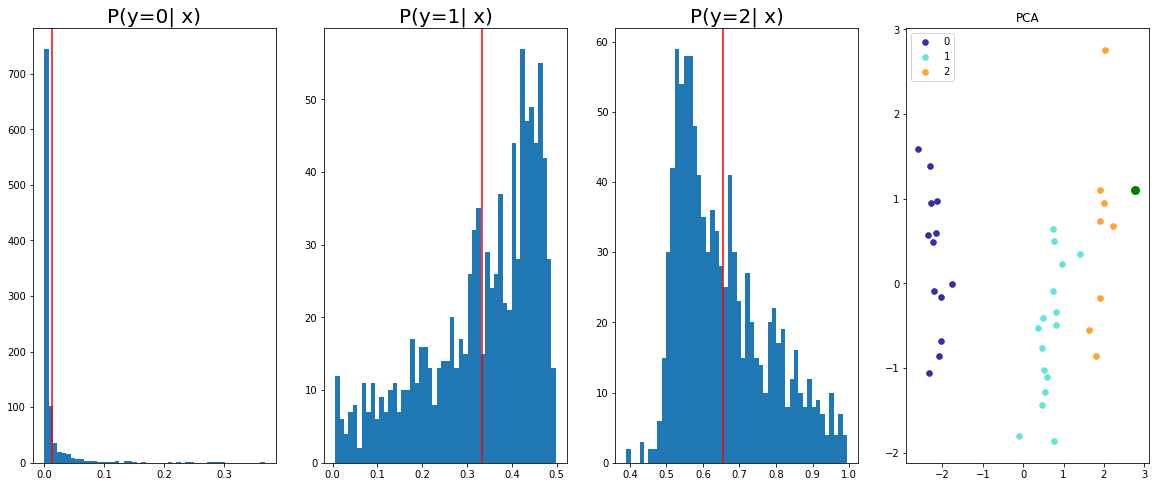

True -> 1
Predicted -> 1
STDS: 0.11047064512968063


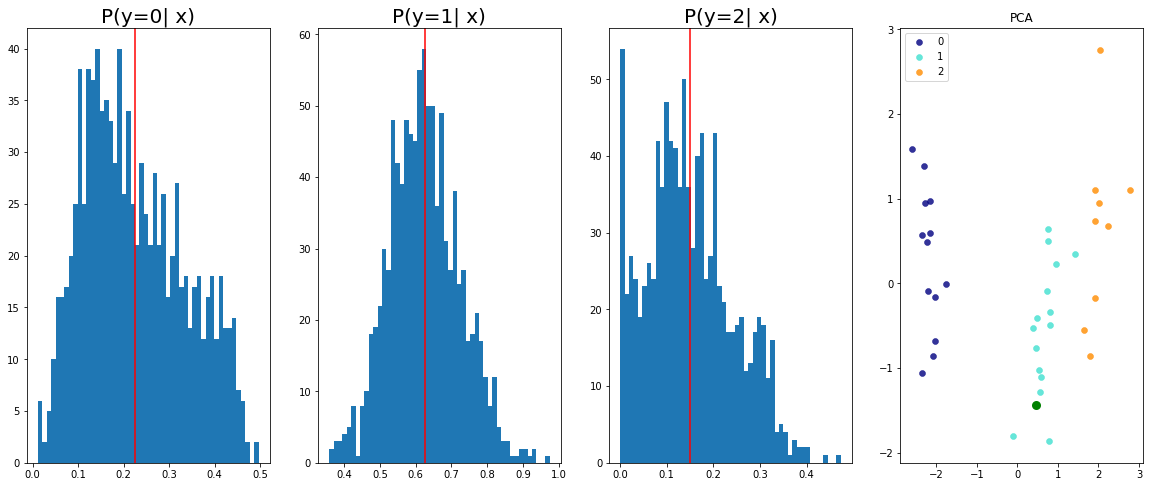

True -> 2
Predicted -> 2
STDS: 0.09543460607528687


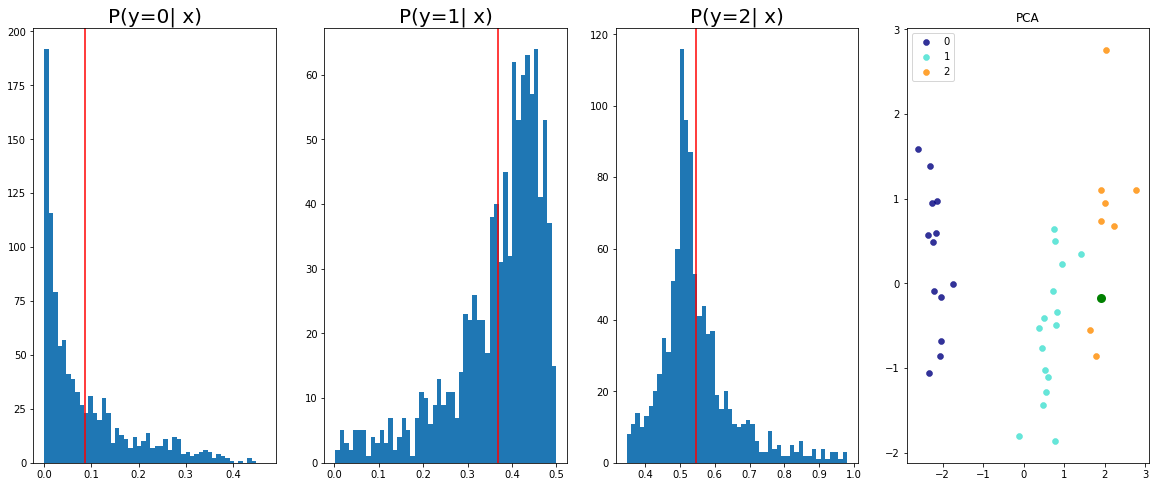

True -> 2
Predicted -> 2
STDS: 0.09992211312055588


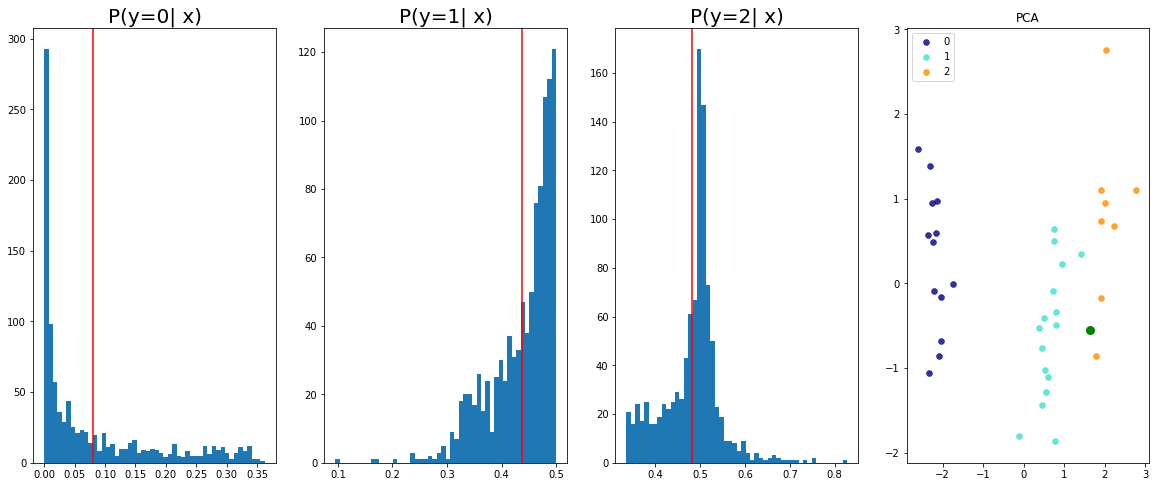

True -> 0
Predicted -> 0
STDS: 0.08229018747806549


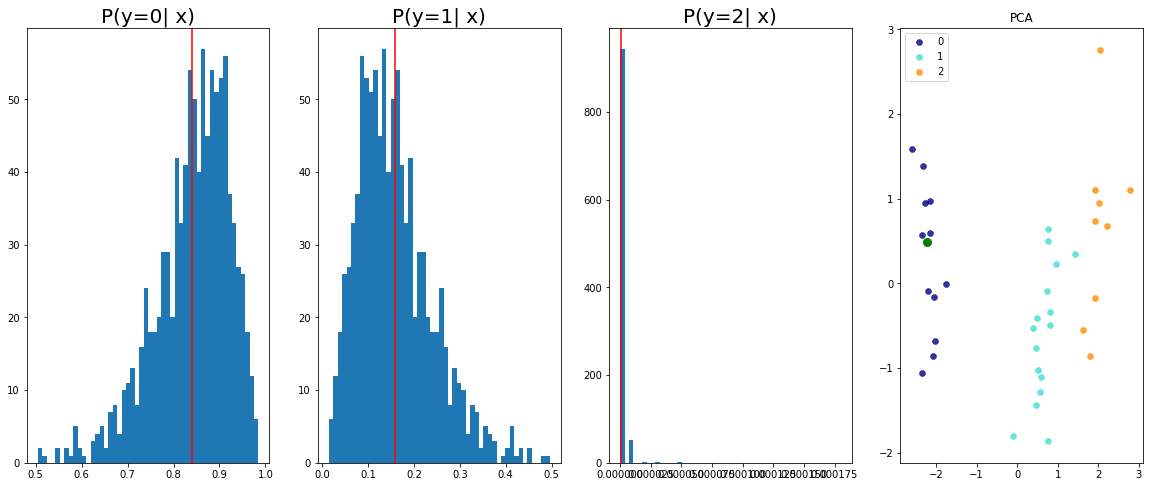

True -> 1
Predicted -> 1
STDS: 0.10388845205307007


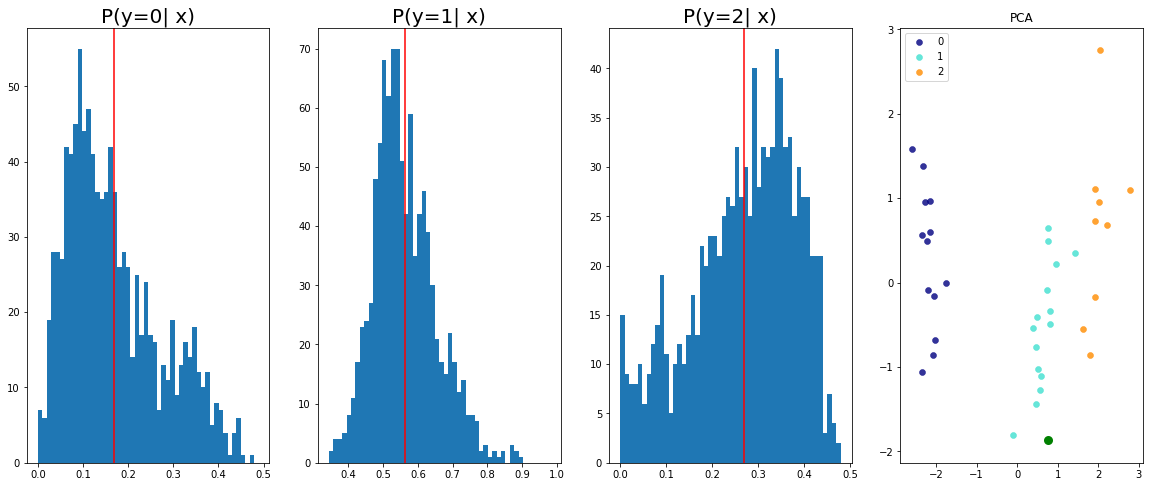

True -> 0
Predicted -> 0
STDS: 0.07828448712825775


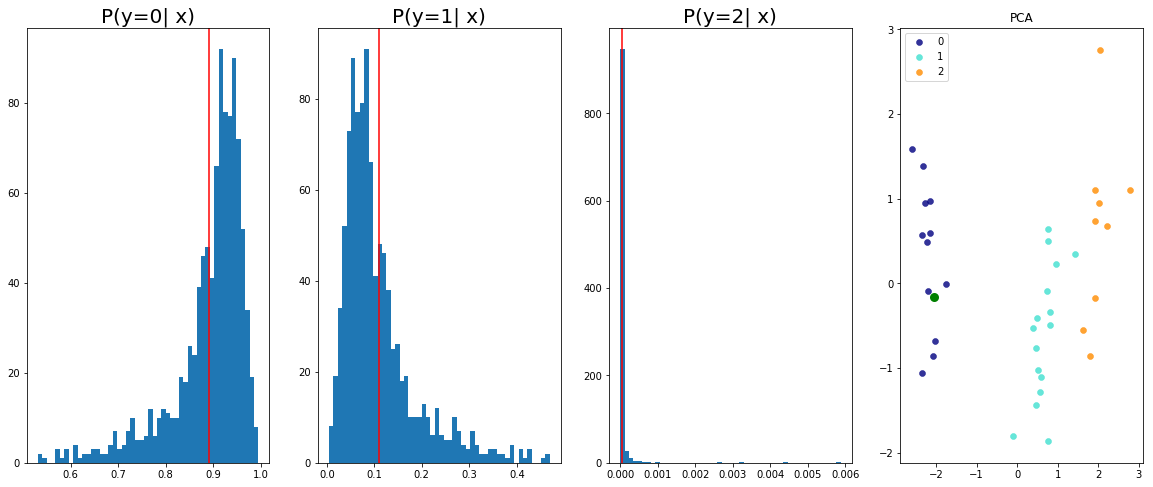

In [29]:
for i in range(len(estimator)):
    plot_prediction_probabilities(estimator=estimator, index_to_plot=i)

In [30]:
# estimator.output_distribution

In [14]:
data_nas = process_reports_nas(reports)
data_nas['version'] = 'Grid Search BackProp'
data_nas

,correlation_id,execution_id,train_percentage,noise,is_bayesian,beta,duration,end_condition,n_parameters,n_nodes,n_connections,f1,accuracy,version
0,nas_v1,08d6a5a2-9092-4947-a5a0-65321cc6b4ed,0.75,0.0,True,0.000001,0:00:00.000016,normal,198,15,84,0.932597,93.263158,Grid Search BackProp
0,nas_v1,2b591dde-a40c-4b89-b87a-8b1405e5874f,0.75,0.0,True,0.000001,0:00:00.000014,normal,942,42,429,0.914497,91.473684,Grid Search BackProp
0,nas_v1,6c92d9b1-79bc-40f2-800e-1dcbc355376f,0.75,0.0,True,0.000001,0:00:00.000029,normal,146,13,60,0.934205,93.421053,Grid Search BackProp
0,nas_v1,d22e3a31-33b4-426f-a230-58b49b7f2dd2,0.75,0.0,True,0.000001,0:00:00.000015,normal,198,15,84,0.940826,94.078947,Grid Search BackProp


In [41]:
data = pd.concat([data_ne, data_nas])
data.dropna(axis=1, inplace=True)
data.drop(columns=['correlation_id', 'execution_id', ], inplace=True)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,accuracy,beta,duration,end_condition,f1,is_bayesian,n_connections,n_nodes,n_parameters,noise,train_percentage,version
0,95.410526,0.000001,0:04:57.346098,normal,0.954199,True,32,15,94,0.0,0.75,Bayesian Neuro-Evolution
1,86.792105,0.000001,0:11:48.839582,normal,0.868889,True,57,28,170,0.0,0.75,Bayesian Neuro-Evolution
2,93.563158,0.000001,0:08:07.872646,normal,0.936056,True,46,22,136,0.0,0.75,Bayesian Neuro-Evolution
3,96.981579,0.000001,0:04:09.267670,normal,0.969852,True,35,15,100,0.0,0.75,Bayesian Neuro-Evolution
4,94.713158,0.000001,0:23:22.603487,normal,0.947125,True,64,31,190,0.0,0.75,Bayesian Neuro-Evolution
0,93.263158,0.000001,0:00:00.000016,normal,0.932597,True,84,15,198,0.0,0.75,Grid Search BackProp
0,91.473684,0.000001,0:00:00.000014,normal,0.914497,True,429,42,942,0.0,0.75,Grid Search BackProp
0,93.421053,0.000001,0:00:00.000029,normal,0.934205,True,60,13,146,0.0,0.75,Grid Search BackProp
0,94.078947,0.000001,0:00:00.000015,normal,0.940826,True,84,15,198,0.0,0.75,Grid Search BackProp


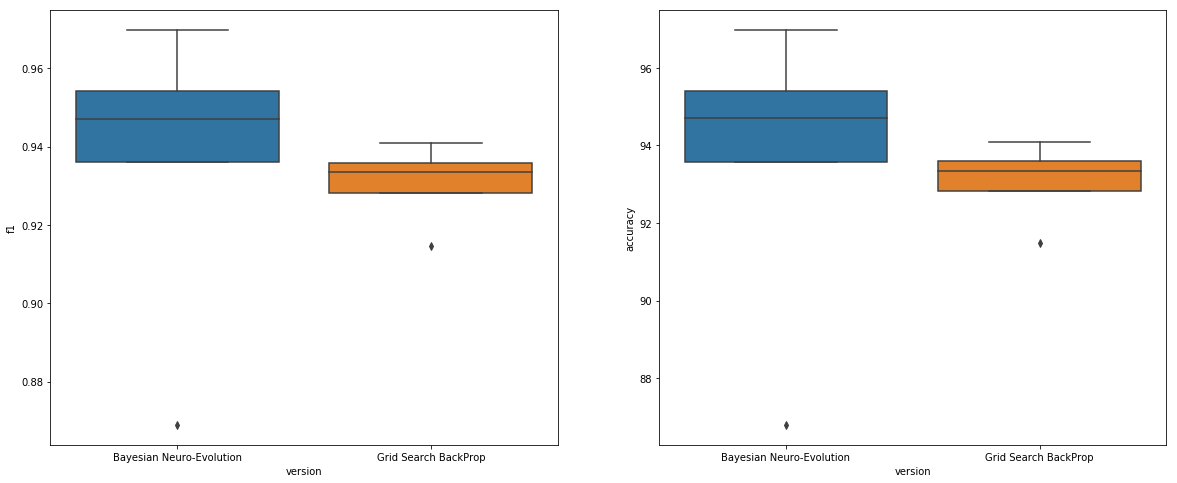

In [45]:
# sns.boxplot(data=data, y='accuracy', x='version')

_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='f1', ax=ax1)
sns.boxplot(data=data, x='version', y='accuracy', ax=ax2)
# ax1.set_ylim([0, 1])
# ax2.set_ylim([0, 100])

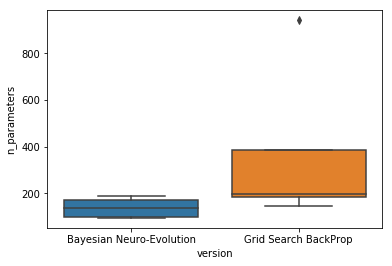

In [47]:
sns.boxplot(data=data, y='n_parameters', x='version')

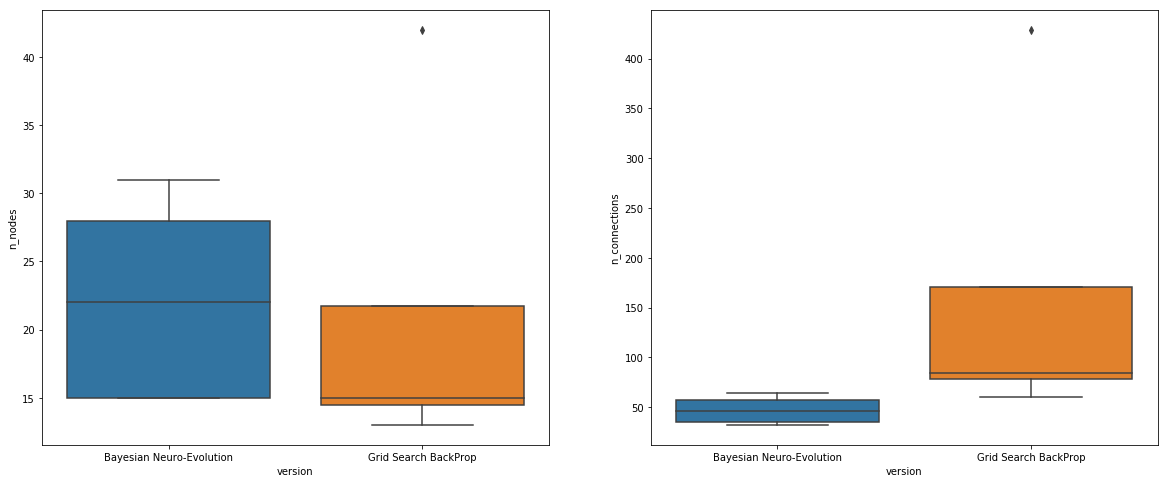

In [46]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data=data, x='version', y='n_nodes', ax=ax1)
sns.boxplot(data=data, x='version', y='n_connections', ax=ax2)

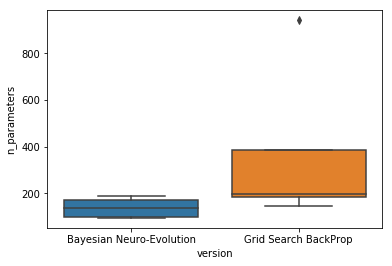

In [43]:
sns.boxplot(data=data, y='n_parameters', x='version')